In [1]:
from pathlib import Path
from LHC_FillingPattern import LHCFillingPattern 
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import pathlib
import pandas as pd
from pprint import pprint
import math
import pyarrow.dataset as ds
from scipy.stats import linregress
from pathlib import Path
from lmfit import Model 

In [2]:
# user settings
beam = "B1"
ip   = "1"
RAWDATA = Path('/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/rawdata')
FILLINFO       = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/fills-info")
fbmodes        = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")
fbmodes[(fbmodes.BMODE == "STABLE") & (fbmodes.duration > 5*3600*1.0e9)].head()

,BMODE,tsStart,tsEnd,QFLAG,duration,duration [m],duration [h],HX:AMODE,injection_scheme
FILLNO,,,,,,,,,
10590,STABLE,1746456976242238525,1746489950314613525,STABLE,32974072375000,549.567873,9.159465,9.0,Single_12b_8_8_8_1bpi_12inj
10591,STABLE,1746496251855238525,1746525571357863525,STABLE,29319502625000,488.658377,8.144306,9.0,Single_12b_8_8_8_1bpi_12inj
10606,STABLE,1746758116976238525,1746778553519613525,STABLE,20436543375000,340.609056,5.676818,9.0,Single_12b_8_8_8_1bpi_12inj
10611,STABLE,1746858552504738525,1746885430361738525,STABLE,26877857000000,447.964283,7.466071,9.0,25ns_75b_74_38_50_12bpi_9inj_3INDIVs
10612,STABLE,1746893747069363525,1746937880245363525,STABLE,44133176000000,735.552933,12.259216,9.0,25ns_75b_74_38_50_12bpi_9inj_3INDIVs


In [3]:

#load variabled
int_var   = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"
bsrt_loc = '5R4' if beam.upper() == 'B1' else '5L4'
int_var   = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"
emitH_var = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_H"
emitV_var = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_V"
loss_b1 = 'UCAP.LHC.LUMI.LOSSES:EffectiveCrossSectionPerBunch:effectiveCrossSectionB1'
loss_b2 = "UCAP.LHC.LUMI.LOSSES:EffectiveCrossSectionPerBunch:effectiveCrossSectionB2"
lev_pv = "LHC.LUMISERVER:LumiLevelingIP1:Enable"
beta_pv     = "HX:BETASTAR_IP1"
xing_pv     = "LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value"
fills = np.array([10665,10666,10671,10673,10675,10676,10685,10689,10690,10701,10717,10721,10732,10709]) 

# Build families

In [4]:
# ------------------------------------------------------------------
# Build Families for ONE fill
# ------------------------------------------------------------------
def build_families_for_fill(
    fillno: int,
    beam: str,
    ip: str,
    RAWDATA: Path,
    long_gap_set=(32, 63),
    small_gap=8,
    F4_offset_after_long=6,    # 7th bunch (bid_first + 6)
    # F5_offset_after_long removed from use; Family_5 now from small-gap trains
    F6_offset_before_small=26, # 27th bunch (bid_first + 26)
    enforce_filled=True,
    intensity_threshold=None,
) -> dict:
    """
    Return dict {Family_1: np.ndarray([...]), ..., Family_8: np.ndarray([...])}
    for the requested fill/beam/ip.

    Family_5 MODIFIED: 15th bunch (bid_first + 14) in trains whose *preceding* gap == small_gap (default 8).
    """

    # --- Fetch filling pattern object ---
    fpat = LHCFillingPattern(fillno, RAWDATA)

    # beam-specific train table & "filled" mask
    if beam.upper() == "B1":
        trains = fpat.bunchtrainsDF_b1.copy()
        filled_slots = fpat.bunches_b1
    else:
        trains = fpat.bunchtrainsDF_b2.copy()
        filled_slots = fpat.bunches_b2

    trains = (
        trains.loc[trains["id"] != 0]
              .sort_values("bid_first")
              .reset_index(drop=True)
    )

    orbit_len = 3564

    # --- optional BUNCH_INTENSITY for filtering ---
    if intensity_threshold is not None:
        int_var = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"
        ser_int = load_series(int_var, RAWDATA, fillno=fillno)  # helper below
        if ser_int.empty:
            arr_intensity = np.zeros(orbit_len, dtype=float)
        else:
            last_vals = np.asarray(ser_int.iloc[-1])
            if last_vals.shape[0] != orbit_len:
                tmp = np.zeros(orbit_len, dtype=float)
                n = min(orbit_len, last_vals.shape[0])
                tmp[:n] = last_vals[:n]
                last_vals = tmp
            arr_intensity = last_vals
    else:
        arr_intensity = None

    # ---- filter helpers ------------------------------------------------
    filled_mask = np.zeros(orbit_len, dtype=bool)
    filled_mask[filled_slots] = True

    def _filter(arr: np.ndarray) -> np.ndarray:
        if arr.size == 0:
            return arr
        arr = arr.astype(int)
        if enforce_filled:
            arr = arr[filled_mask[arr]]
        if arr_intensity is not None and intensity_threshold is not None:
            arr = arr[arr_intensity[arr] >= intensity_threshold]
        return arr

    # ------------------------------------------------------------------
    # Family_1: first bunch of trains whose *preceding* gap is long (32 or 63)
    # ------------------------------------------------------------------
    mask_long = trains["gap"].isin(long_gap_set)
    Family_1 = trains.loc[mask_long, "bid_first"].to_numpy(int)

    # ------------------------------------------------------------------
    # Family_2: last bunch of a train that is followed by a long (≥31) gap
    # ------------------------------------------------------------------
    next_start = trains["bid_first"].shift(-1).fillna(orbit_len).astype(int)
    trains["gap_after"] = next_start - trains["bid_last"] - 1
    mask_big_gap = trains["gap_after"] >= 31
    Family_2 = trains.loc[mask_big_gap, "bid_last"].to_numpy(int)

    # ------------------------------------------------------------------
    # Family_3: first slot of max LR encounter per train
    # ------------------------------------------------------------------
    lr = fpat.lrencounters[beam][f"ip{ip}"]  # length-3564 array
    peak_slots = []
    for _, row in trains.iterrows():
        bids = np.asarray(row["bids"], dtype=int)
        lr_train = lr[bids]
        max_val = lr_train.max()
        first_idx = np.where(lr_train == max_val)[0][0]
        peak_slots.append(bids[first_idx])
    Family_3 = np.asarray(peak_slots, dtype=int)

    # ------------------------------------------------------------------
    # Family_4: 7th bunch in long-gap trains (bid_first + 6)
    # ------------------------------------------------------------------
    Family_4 = (trains.loc[mask_long, "bid_first"] + F4_offset_after_long).to_numpy(int)

    # ------------------------------------------------------------------
    # Family_5 (MODIFIED): 15th bunch in trains whose *preceding* gap == small_gap
    #                      (e.g., gap == 8). Require nbunches >= 15.
    # ------------------------------------------------------------------
    mask_gap_small_15 = (trains["gap"] == small_gap) & (trains["nbunches"] >= 15)
    cand_F5 = (trains.loc[mask_gap_small_15, "bid_first"] + 14).to_numpy(int)
    # clip to each selected train's end (safety)
    last_F5 = trains.loc[mask_gap_small_15, "bid_last"].to_numpy(int)
    Family_5 = cand_F5[cand_F5 <= last_F5]

    # ------------------------------------------------------------------
    # Family_6: 27th bunch IN THE TRAIN *BEFORE* a gap==8 train
    # ------------------------------------------------------------------
    rows_gap8 = trains["gap"] == small_gap
    train_before_gap8 = trains.shift(1).loc[rows_gap8].dropna()
    mask_nbunch27 = train_before_gap8["nbunches"] >= (F6_offset_before_small + 1)
    Family_6 = (train_before_gap8.loc[mask_nbunch27, "bid_first"] + F6_offset_before_small).to_numpy(int)

    # ------------------------------------------------------------------
    # Family_7: first bunch AFTER an 8-slot gap (the gap8 train itself)
    # ------------------------------------------------------------------
    Family_7 = trains.loc[rows_gap8, "bid_first"].to_numpy(int)

    # ------------------------------------------------------------------
    # Family_8: last bunch BEFORE each gap8 (the last bunch of the previous train)
    # ------------------------------------------------------------------
    train_before_gap8_full = trains.shift(1).loc[rows_gap8].dropna()
    Family_8 = train_before_gap8_full["bid_last"].astype(int).to_numpy()

    # ------------------------------------------------------------------
    # apply filters
    # ------------------------------------------------------------------
    fam_dict = {
        "Family_1": _filter(Family_1),
        "Family_2": _filter(Family_2),
        "Family_3": _filter(Family_3),
        "Family_4": _filter(Family_4),
        "Family_5": _filter(Family_5),
        "Family_6": _filter(Family_6),
        "Family_7": _filter(Family_7),
        "Family_8": _filter(Family_8),
    }

    # report
    #print(f"\n=== Families for fill {fillno} ({beam}, {ip}) ===")
    ##for k, v in fam_dict.items():
        #print(f"{k}: n={len(v)}  slots={v}")

    return fam_dict


# ------------------------------------------------------------------
# Minimal load_series helper (same as in larger module)
# ------------------------------------------------------------------
def load_series(var: str, RAWDATA: Path, fillno: int) -> pd.Series:
    root = RAWDATA / f"HX:FILLN={fillno}"
    parts = []
    for pq in root.rglob("*.parquet"):
        try:
            df = pd.read_parquet(pq, columns=[var])
        except Exception:
            continue
        idx = pd.to_datetime(df.index, utc=True, errors="coerce")
        ser = pd.Series(df[var].to_numpy(), index=idx, name=var)
        parts.append(ser.dropna())
    if not parts:
        return pd.Series(dtype=float, name=var)
    return pd.concat(parts).sort_index()


In [5]:
fams_by_fill = {}
records = []   # for long DataFrame

for fillno in fills:
    fams = build_families_for_fill(
        fillno=fillno,
        beam=beam,
        ip=ip,
        RAWDATA=RAWDATA,
        # (optionally pass thresholds/offset overrides if needed)
    )
    fams_by_fill[fillno] = fams
# ------------------------------------------------------------------
# group back by fill -> dict, then assemble as columns
wide_rows = []
for fillno, fams in fams_by_fill.items():
    row = {"fill": fillno}
    for fam_name, slots in fams.items():
        row[fam_name] = np.array(slots, dtype=int)  # ragged arrays stored as objects
    wide_rows.append(row)

df_families_wide = pd.DataFrame(wide_rows)
print("df_families_wide shape:", df_families_wide.shape)
display(df_families_wide)

df_families_wide shape: (14, 9)


,fill,Family_1,Family_2,Family_3,Family_4,Family_5,Family_6,Family_7,Family_8
0,10665,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
1,10666,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
2,10671,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
3,10673,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
4,10675,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
5,10676,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
6,10685,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
7,10689,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
8,10690,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
9,10701,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 1

# Build Ips

In [6]:
def _ip_collision_sets_for_fill(fillno: int, beam: str, RAWDATA: Path):
    """
    Return dict with Python sets for slots colliding at each IP-class:
        {'15': set(...), '2': set(...), '8': set(...)}
    where '15' is the combined IP1+IP5 mask exposed by fpat.collbid_ip15.
    """
    fpat = LHCFillingPattern(fillno, RAWDATA)

    if beam.upper() == "B1":
        ip15 = np.asarray(fpat.collbid_ip15["B1"], dtype=int)
        ip2  = np.asarray(fpat.collbid_ip2 ["B1"], dtype=int)
        ip8  = np.asarray(fpat.collbid_ip8 ["B1"], dtype=int)
    else:
        ip15 = np.asarray(fpat.collbid_ip15["B2"], dtype=int)
        ip2  = np.asarray(fpat.collbid_ip2 ["B2"], dtype=int)
        ip8  = np.asarray(fpat.collbid_ip8 ["B2"], dtype=int)

    return {
        "15": set(ip15),
        "2":  set(ip2),
        "8":  set(ip8),
    }

# Classify a numpy array of slots into exclusive IP groups

def _classify_slots_by_ip(slots: np.ndarray, set15, set2, set8):
    """
    Given 1D int array `slots` and three sets (IP15, IP2, IP8),
    return dict {ip_group_label: np.ndarray([...])}.
    """
    slots = np.asarray(slots, dtype=int)

    # for each slot, boolean membership
    in15 = np.array([s in set15 for s in slots], dtype=bool)
    in2  = np.array([s in set2  for s in slots], dtype=bool)
    in8  = np.array([s in set8  for s in slots], dtype=bool)

    # masks
    m15_only   =  in15 & ~in2 & ~in8
    m2_only    = ~in15 &  in2 & ~in8
    m8_only    = ~in15 & ~in2 &  in8

    m15_2      =  in15 &  in2 & ~in8
    m15_8      =  in15 & ~in2 &  in8
    m2_8       = ~in15 &  in2 &  in8

    m15_2_8    =  in15 &  in2 &  in8

    # any that did not match any of above (should be none or "non colliding")
    mnone      = ~(m15_only | m2_only | m8_only | m15_2 | m15_8 | m2_8 | m15_2_8)

    return {
        "15_only":   slots[m15_only],
        "2_only":    slots[m2_only],
        "8_only":    slots[m8_only],
        "15_2":      slots[m15_2],
        "15_8":      slots[m15_8],
        "2_8":       slots[m2_8],
        "15_2_8":    slots[m15_2_8],
        "none":      slots[mnone],
    }

# Main: explode fams_by_fill into IP-partitioned long & summary DFs
def build_family_ip_partitions(
    fams_by_fill: dict,
    RAWDATA: Path,
    beam: str,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Parameters
    ----------
    fams_by_fill : dict
        {fill: {"Family_1": array([...]), ...}}
    RAWDATA : Path
        root rawdata path
    beam : str
        'B1' or 'B2'

    Returns
    -------
    df_families_ip_long : DataFrame
        columns: fill, family, ip_group, slot
    df_families_ip_summary : DataFrame
        columns: fill, family, 15_only, 2_only, 8_only, 15_2, 15_8, 2_8, 15_2_8, none
        counts per group.
    """
    long_records = []
    summary_records = []

    for fillno, fams in fams_by_fill.items():
        # Get IP sets for this fill
        ip_sets = _ip_collision_sets_for_fill(fillno, beam, RAWDATA)
        set15, set2, set8 = ip_sets["15"], ip_sets["2"], ip_sets["8"]

        for fam_name, slots in fams.items():
            slots = np.asarray(slots, dtype=int)

            part_dict = _classify_slots_by_ip(slots, set15, set2, set8)

            # long rows
            for ip_group, arr in part_dict.items():
                for s in arr:
                    long_records.append({
                        "fill": fillno,
                        "family": fam_name,
                        "ip_group": ip_group,
                        "slot": int(s),
                    })

            # summary counts
            rec = {
                "fill": fillno,
                "family": fam_name,
            }
            for ip_group, arr in part_dict.items():
                rec[ip_group] = int(len(arr))
            summary_records.append(rec)

    # assemble long
    if long_records:
        df_families_ip_long = (
            pd.DataFrame.from_records(long_records)
              .sort_values(["fill", "family", "ip_group", "slot"])
              .reset_index(drop=True)
        )
    else:
        df_families_ip_long = pd.DataFrame(columns=["fill", "family", "ip_group", "slot"])

    # assemble summary
    if summary_records:
        df_families_ip_summary = (
            pd.DataFrame.from_records(summary_records)
              .sort_values(["fill", "family"])
              .reset_index(drop=True)
        )
    else:
        df_families_ip_summary = pd.DataFrame(columns=["fill", "family"])

    return df_families_ip_long, df_families_ip_summary

df_families_ip_long, df_families_ip_summary = build_family_ip_partitions(
    fams_by_fill=fams_by_fill,
    RAWDATA=RAWDATA,
    beam=beam,          # same beam as used when building families
)

print("df_families_ip_long shape:", df_families_ip_long.shape)
display(df_families_ip_long.head())

print("df_families_ip_summary shape:", df_families_ip_summary.shape)
display(df_families_ip_summary.head(9))

df_families_ip_long shape: (4494, 4)


,fill,family,ip_group,slot
0,10665,Family_1,15_2_8,1843
1,10665,Family_1,15_2_8,1996
2,10665,Family_1,15_2_8,2192
3,10665,Family_1,15_2_8,2388
4,10665,Family_1,15_8,55


df_families_ip_summary shape: (112, 10)


,fill,family,15_only,2_only,8_only,15_2,15_8,2_8,15_2_8,none
0,10665,Family_1,5,0,0,0,10,0,4,0
1,10665,Family_2,0,0,0,1,6,0,12,0
2,10665,Family_3,0,0,0,2,3,0,63,0
3,10665,Family_4,0,0,0,5,1,0,13,0
4,10665,Family_5,0,0,0,1,2,0,46,0
5,10665,Family_6,0,0,0,2,1,0,46,0
6,10665,Family_7,2,0,0,0,36,0,11,0
7,10665,Family_8,0,0,0,2,1,0,46,0
8,10666,Family_1,5,0,0,0,10,0,4,0


# Injection

In [7]:
# ---------------------------------------------
# Imports
# ---------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model
import warnings

# ---------------------------------------------
# CONFIG
# ---------------------------------------------
THRESHOLD    = 1e11      # intensity cut to define t0
PLANE        = 'H'       # 'H' or 'V'
N_PLOTS      = 8
FIGSIZE      = (9, 3)

# Fit / weighting
F_SCALE      = 0.1
REL_ERR      = 0.05      # 5% rel error
ABS_ERR_FLOOR= 0.02      # absolute floor in emittance units
MIN_ERR      = 1e-12
MIN_PTS      = 5         # minimum points in fit segment
MIN_DT_H     = 0.15      # minimum span in hours (~9 min)
MAX_WEIGHT   = 1e4       # cap weights to avoid dominance

# ---------------------------------------------
# EXTERNALS YOU MUST PROVIDE:
#   fbmodes, RAWDATA, fills, beam, ip
#   build_families_for_fill(fillno, beam, ip, RAWDATA)
# ---------------------------------------------

# ---------------------------
# Helpers
# ---------------------------
def load_INJPHYS(fno: int, var: str) -> pd.Series:
    sub  = fbmodes.loc[fno]
    rows = sub.query("BMODE=='INJPHYS'").sort_values("tsStart")
    if rows.empty:
        rows = sub.sort_values("tsStart").iloc[[0]]
    t0 = pd.to_datetime(rows["tsStart"].iloc[0], utc=True)
    t1 = pd.to_datetime(rows["tsEnd"].iloc[0],   utc=True)

    parts = []
    pq_dir = RAWDATA / f"HX:FILLN={fno}"
    for pq in pq_dir.rglob("*.parquet"):
        try:
            df = pd.read_parquet(pq, columns=[var])
        except Exception as e:
            warnings.warn(f"Skipping {pq!r} (read error: {e})", UserWarning)
            continue
        ser = df[var]
        ser.index = pd.to_datetime(df.index, utc=True, errors="coerce")
        parts.append(ser.dropna())

    if not parts:
        raise RuntimeError(f"No data for PV {var!r} in INJPHYS of fill {fno}")

    full = pd.concat(parts).sort_index()
    return full.loc[t0:t1]
def extract_slot(ser: pd.Series, slot: int) -> pd.Series:
    return ser.apply(lambda a: a[slot] if hasattr(a, '__len__') and len(a) > slot else np.nan)

def segment_ok(seg: pd.Series) -> bool:
    if seg is None or seg.empty: return False
    if len(seg) < MIN_PTS:       return False
    dt_h = (seg.index[-1] - seg.index[0]).total_seconds()/3600.0
    return dt_h >= MIN_DT_H

# ---------------------------
# Weighted linear fit (robust)
# ---------------------------
_line_model = Model(lambda x, m, b: m*x + b)

def robust_line(x_hours: np.ndarray, y: np.ndarray, f_scale=F_SCALE):
    yerr = np.maximum(np.maximum(REL_ERR*np.abs(y), ABS_ERR_FLOOR), MIN_ERR)
    w    = 1.0 / yerr
    w    = np.minimum(w, MAX_WEIGHT)

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning, module='lmfit')
        res = _line_model.fit(
            y, x=x_hours,
            m=0.0, b=y[0],
            weights=w,
            method='least_squares',
            fit_kws={'loss': 'soft_l1', 'f_scale': f_scale}
        )
    m  = res.params['m'].value
    b  = res.params['b'].value
    sm = res.params['m'].stderr or np.nan
    return m, b, sm, res

# ---------------------------------------------
# Aggregation helper: weighted mean + CI + spread
# ---------------------------------------------
def _wmean_and_ci(pairs):
    # pairs: list of (value, sigma)
    if not pairs:
        return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 0)

    vals = np.array([p[0] for p in pairs], float)
    sigs = np.array([p[1] for p in pairs], float)

    ok = np.isfinite(vals) & np.isfinite(sigs) & (sigs > 0)
    if ok.sum() == 0:
        return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 0)

    w    = 1.0 / sigs[ok]**2
    mean = np.sum(w*vals[ok]) / np.sum(w)
    sem  = (1.0/np.sum(w))**0.5
    lo95 = mean - 1.96*sem
    hi95 = mean + 1.96*sem

    std  = np.std(vals[ok], ddof=1) if ok.sum() > 1 else np.nan
    madv = np.median(np.abs(vals[ok] - np.median(vals[ok]))) if ok.sum() > 1 else np.nan
    mad  = 1.4826*madv if ok.sum() > 1 else np.nan

    return mean, sem, lo95, hi95, std, mad, ok.sum()

# -------------------------------------------------
# Compute per-slot robust slopes, then family stats
# -------------------------------------------------
def one_fill_family_rates_robust(
    fno: int,
    beam: str,
    families: dict,
    threshold: float = THRESHOLD
) -> tuple[pd.DataFrame, dict]:

    bsrt_loc = '5R4' if beam.upper() == 'B1' else '5L4'

    int_var = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"
    H_var   = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_H"
    V_var   = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_V"

    I  = load_INJPHYS(fno, int_var)
    EH = load_INJPHYS(fno, H_var)
    EV = load_INJPHYS(fno, V_var)

    per_h, per_v = {}, {}
    fits = {}

    for fam, slots in families.items():
        fits[fam] = {}
        for slot in slots:
            Ii = extract_slot(I, slot)
            above = Ii[Ii >= threshold]
            if above.empty:
                per_h[slot] = (np.nan, np.nan)
                per_v[slot] = (np.nan, np.nan)
                continue

            t0 = above.index[0]

            Hs = extract_slot(EH, slot).loc[t0:].dropna()
            Vs = extract_slot(EV, slot).loc[t0:].dropna()

            # Quality cuts
            if not segment_ok(Hs) or not segment_ok(Vs):
                per_h[slot] = (np.nan, np.nan)
                per_v[slot] = (np.nan, np.nan)
                continue

            xh = (Hs.index - t0).total_seconds()/3600.0
            xv = (Vs.index - t0).total_seconds()/3600.0

            sh, ih, sh_err, _ = robust_line(xh, Hs.values)
            sv, iv, sv_err, _ = robust_line(xv, Vs.values)

            per_h[slot] = (sh, sh_err)
            per_v[slot] = (sv, sv_err)
            fits[fam][slot] = {'H': (sh, ih, sh_err, t0, Hs),
                               'V': (sv, iv, sv_err, t0, Vs)}

    # aggregate per family
    rows = []
    for fam, slots in families.items():
        h_pairs = [per_h[s] for s in slots if s in per_h]
        v_pairs = [per_v[s] for s in slots if s in per_v]

        H_mean, H_sem, H_lo95, H_hi95, H_std, H_mad, H_n = _wmean_and_ci(h_pairs)
        V_mean, V_sem, V_lo95, V_hi95, V_std, V_mad, V_n = _wmean_and_ci(v_pairs)

        rows.append({
            "fill":              fno,
            "family":            fam,
            "H_rate_mean_w":     H_mean,
            "H_err_family":      H_sem,
            "H_lo95":            H_lo95,
            "H_hi95":            H_hi95,
            "H_std_slots":       H_std,
            "H_mad_slots":       H_mad,
            "H_n_slots":         H_n,
            "V_rate_mean_w":     V_mean,
            "V_err_family":      V_sem,
            "V_lo95":            V_lo95,
            "V_hi95":            V_hi95,
            "V_std_slots":       V_std,
            "V_mad_slots":       V_mad,
            "V_n_slots":         V_n,
        })

    df = pd.DataFrame(rows).set_index(["fill","family"])
    return df, fits

# ---------------------------------------------
# Plot one slot
# ---------------------------------------------
def plot_slot_with_fit(slot_fit_tuple, plane='H', figsize=FIGSIZE, label=None):
    slope, intercept, _, t0, ser = slot_fit_tuple
    x = (ser.index - t0).total_seconds()/3600.0
    y_fit = intercept + slope*x

    plt.figure(figsize=figsize)
    plt.plot(ser.index, ser.values, label='Raw', alpha=0.6)
    plt.plot(ser.index, y_fit, label='Weighted robust fit', linewidth=2)
    plt.xlabel('Time'); plt.ylabel(f'Emittance {plane}')
    plt.title(label if label else 'Slot'); plt.legend()
    plt.tight_layout(); plt.show()

# ---------------------------------------------
# Plot families (choose error bar)
# ---------------------------------------------
def plot_family_err(df_fill, plane='H', errtype='sem', title_extra=''):
    mean_col = f"{plane}_rate_mean_w"
    fams  = df_fill.index.get_level_values('family')
    means = df_fill[mean_col].to_numpy()

    fig, ax = plt.subplots(figsize=(11, 3))
    if errtype.lower() == 'ci':
        lo_col = f"{plane}_lo95"; hi_col = f"{plane}_hi95"
        ci_lo  = df_fill[lo_col].to_numpy()
        ci_hi  = df_fill[hi_col].to_numpy()
        yerr   = np.vstack([means - ci_lo, ci_hi - means])
        label  = f'{plane}-plane weighted mean ±95% CI'
    else:
        err_col = f"{plane}_err_family"
        yerr    = df_fill[err_col].to_numpy()
        label   = f'{plane}-plane error on weighted mean (1σ)'

    ax.errorbar(fams, means, yerr=yerr,
                fmt='o', capsize=3, elinewidth=1.5, label=label)
    ax.set_xticklabels(fams, rotation=45, ha='right')
    ax.set_ylabel(f'Growth rate ({plane})')
    ax.set_title(title_extra or f'{plane}-plane slopes ({errtype.upper()} bars)')
    ax.legend()
    fig.tight_layout()
    plt.show()

# -------------------------------------------------
# DRIVER
# -------------------------------------------------
all_tables = []
all_fits   = {}

for fno in fills:
    fams = build_families_for_fill(fillno=fno, beam=beam, ip=ip, RAWDATA=RAWDATA)
    df_this, fits_this = one_fill_family_rates_robust(fno, beam, fams, threshold=THRESHOLD)
    all_tables.append(df_this)
    all_fits[fno] = fits_this

df_inj_rates = (pd.concat(all_tables, axis=0, ignore_index=False)
                  .reset_index()
                  .set_index(['fill','family'])
                  .sort_index())

display(df_inj_rates)


H_rate_mean_w  H_err_family    H_lo95    H_hi95  H_std_slots  \
fill  family                                                                   
10665 Family_1       0.465283      0.013103  0.439602  0.490965     0.125304   
      Family_2       0.972842      0.027721  0.918508  1.027175     0.065920   
      Family_3       0.865486      0.013786  0.838464  0.892507     0.109695   
      Family_4       0.586707      0.016753  0.553870  0.619543     0.071606   
      Family_5       0.918467      0.016950  0.885245  0.951689     0.114661   
...                       ...           ...       ...       ...          ...   
10732 Family_4       0.839938      0.029330  0.782451  0.897426     0.059991   
      Family_5       0.979706      0.021818  0.936943  1.022470     0.093593   
      Family_6       1.011217      0.022978  0.966179  1.056254     0.093472   
      Family_7       1.048112      0.023785  1.001494  1.094730     0.083448   
      Family_8       0.985974      0.021865  0.943118  1.028830     0.110904   

                H_mad_slots  H_n_slots  V_rate_mean_w  V_err_family    V_lo95  \
fill  family                                                                    
10665 Family_1     0.128843         13       0.348503      0.011695  0.325580   
      Family_2     0.076922         13       0.430549      0.012597  0.405859   
      Family_3     0.097128         47       0.266826      0.003932  0.259119   
      Family_4     0.058326         13       0.251608      0.007717  0.236484   
      Family_5     0.111789         34       0.233825      0.004405  0.225192   
...                     ...        ...            ...           ...       ...   
10732 Family_4     0.046014         14       0.210341      0.006429  0.197739   
      Family_5     0.082996         37       0.251519      0.004240  0.243209   
      Family_6     0.058964         37       0.261336      0.004672  0.252180   
      Family_7     0.079975         37       0.437712      0.008789  0.420485   
      Family_8     0.085634         37       0.286398      0.006548  0.273565   

                  V_hi95  V_std_slots  V_mad_slots  V_n_slots  
fill  family                                                   
10665 Family_1  0.371426     0.049794     0.031599         13  
      Family_2  0.455240     0.054871     0.036113         13  
      Family_3  0.274532     0.061789     0.049236         47  
      Family_4  0.266733     0.064610     0.062919         13  
      Family_5  0.242459     0.055297     0.049967         34  
...                  ...          ...          ...        ...  
10732 Family_4  0.222942     0.036421     0.024688         14  
      Family_5  0.259828     0.038984     0.045083         37  
      Family_6  0.270492     0.051502     0.053300         37  
      Family_7  0.454940     0.062833     0.070444         37  
      Family_8  0.299231     0.053269     0.039735         37  

[112 rows x 14 columns]

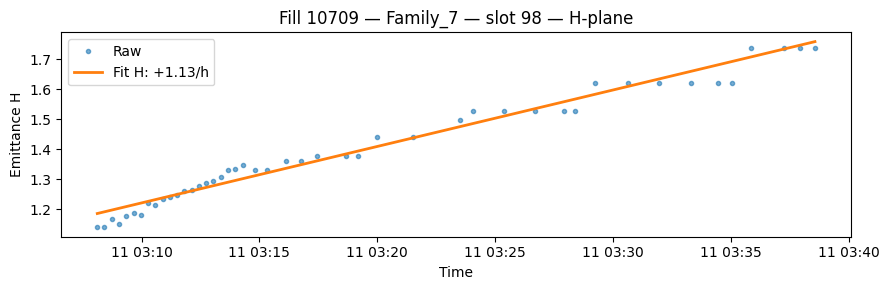

In [8]:
PLANE_DEFAULT = 'H'   
from typing import Optional
# ---------------------------------------------
# Plot one slot (raw + fit overlay)
# ---------------------------------------------
def plot_slot_with_fit(slot_fit_tuple, plane='H', figsize=FIGSIZE, label=None):
    slope, intercept, _, t0, ser = slot_fit_tuple
    x = (ser.index - t0).total_seconds()/3600.0
    y_fit = intercept + slope*x

    plt.figure(figsize=figsize)
    plt.plot(ser.index, ser.values, '.', label='Raw', alpha=0.6)
    plt.plot(ser.index, y_fit, '-', label=f'Fit {plane}: {slope:+.3g}/h', linewidth=2)
    plt.xlabel('Time'); plt.ylabel(f'Emittance {plane}')
    plt.title(label if label else 'Slot'); plt.legend()
    plt.tight_layout(); plt.show()

# ---------------------------------------------
# NEW: pick ONE fill, ONE family, ONE slot and plot
# ---------------------------------------------
def plot_one_fill_family_slot(
    fno: int,
    family: str,
    beam: str,
    plane: str = PLANE_DEFAULT,
    slot: Optional[int] = None,          # <-- fix here
    threshold: float = THRESHOLD,
):
    """
    Compute (if needed) and plot the raw INJPHYS emittance and its robust fit
    for a selected slot within the given family and fill.
    """
    plane = plane.upper()
    if plane not in ('H','V'):
        raise ValueError("plane must be 'H' or 'V'")

    fams = build_families_for_fill(fillno=fno, beam=beam, ip=ip, RAWDATA=RAWDATA)
    slots = list(fams.get(family, []))
    if not slots:
        raise RuntimeError(f"No slots for family {family} in fill {fno}.")
    if slot is None:
        slot = int(slots[0])
    elif slot not in slots:
        raise RuntimeError(f"Requested slot {slot} not in family {family}. Available: {slots}")

    # run the analysis for this fill (fast enough; loads once and fits only used slots)
    df_this, fits_this = one_fill_family_rates_robust(fno=fno, beam=beam, families={family: slots}, threshold=threshold)

    if family not in fits_this or slot not in fits_this[family]:
        raise RuntimeError(f"No fit stored for family {family}, slot {slot} in fill {fno}.")

    fit_tuple = fits_this[family][slot][plane]
    if fit_tuple is None or not np.isfinite(fit_tuple[0]):
        raise RuntimeError(f"Invalid {plane}-plane fit for family {family}, slot {slot} in fill {fno}.")

    label = f"Fill {fno} — {family} — slot {slot} — {plane}-plane"
    plot_slot_with_fit(fit_tuple, plane=plane, figsize=FIGSIZE, label=label)
    return fit_tuple  # return in case you want to inspect values

# -------------------------------------------------
# EXAMPLE: choose ONE fill/family/slot and plot
# -------------------------------------------------
# Change these to what you want to inspect:
EX_FILL   = fills[13]            # or a specific number, e.g. 10709
EX_FAMILY = 'Family_7'          # pick your family
EX_PLANE  = 'H'                 # 'H' or 'V'
EX_SLOT   = None                # None = first slot in the family; or give an int slot id

# Use precomputed all_fits if available to avoid recomputing:
if EX_FILL in all_fits and EX_FAMILY in all_fits[EX_FILL]:
    # If we already have fits, plot directly from them
    fam_dict = all_fits[EX_FILL][EX_FAMILY]
    # choose slot
    if EX_SLOT is None:
        EX_SLOT = sorted(fam_dict.keys())[0]
    fit_tuple = fam_dict[EX_SLOT][EX_PLANE]
    plot_slot_with_fit(
        fit_tuple,
        plane=EX_PLANE,
        figsize=FIGSIZE,
        label=f"Fill {EX_FILL} — {EX_FAMILY} — slot {EX_SLOT} — {EX_PLANE}-plane"
    )
else:
    # Otherwise, compute and plot for that single fill/family
    plot_one_fill_family_slot(EX_FILL, EX_FAMILY, beam, plane=EX_PLANE, slot=EX_SLOT, threshold=THRESHOLD)


## Plots

/tmp/ipykernel_1592512/1071891812.py:244: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(fams, rotation=45, ha='right')


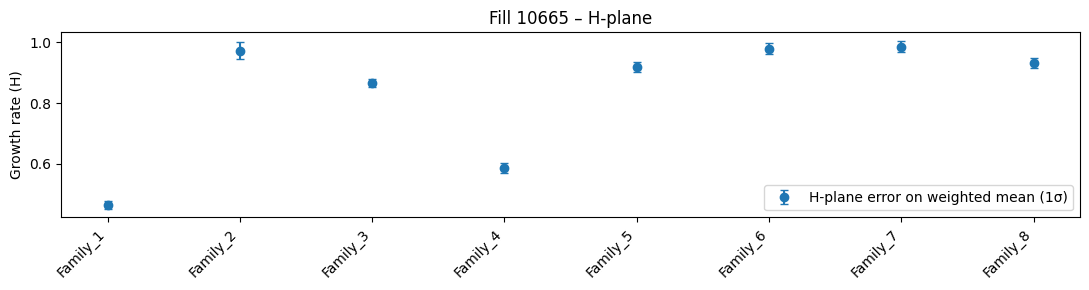

/tmp/ipykernel_1592512/1071891812.py:244: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(fams, rotation=45, ha='right')


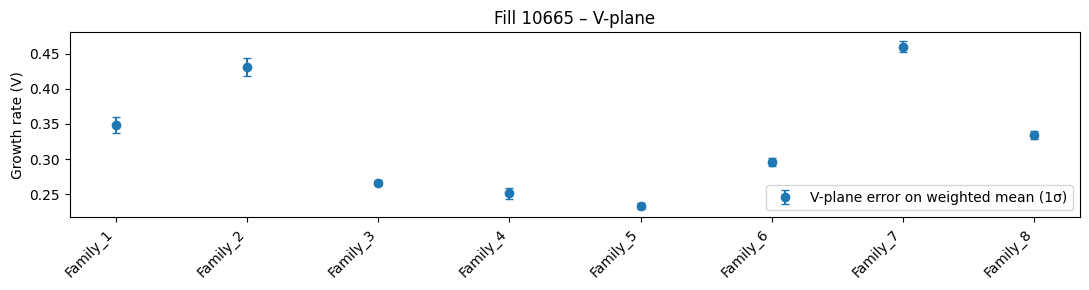

In [9]:

# ---------------------------------------------
# Example family plots
# ---------------------------------------------
fno_plot   = fills[0]
df_fill    = df_inj_rates.loc[fno_plot]

# Error bars = family slope error (SEM, 1σ)
plot_family_err(df_fill, plane=PLANE, errtype='sem',
                title_extra=f'Fill {fno_plot} – {PLANE}-plane')
plot_family_err(
    df_fill,
    plane='V',
    errtype='sem',
    title_extra=f'Fill {fno_plot} – V-plane'
)


# Stable

In [10]:
# ---------------------------------------------
# Imports & config (same as before)
# ---------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from lmfit import Model
import warnings

ip              = 1
RAWDATA         = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/rawdata")
BETA_PV         = 'HX:BETASTAR_IP1'
XING_PV         = 'LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value'
LEV_PV          = "LHC.LUMISERVER:LumiLevelingIP1:Enable"
THRESH_CA       = 120.0

N_PLOTS         = 8
FIGSIZE_SLOT    = (9, 3)
FIGSIZE_ERR     = (11, 4)

# Fit settings
F_SCALE         = 0.1
REL_ERR         = 0.05
ABS_ERR_FLOOR   = 0.02
MIN_ERR         = 1e-12

MAKE_HOURLY     = True   # set False if you *only* want optics windows

# you still need: fbmodes, fills, build_families_for_fill, beam
# ---------------------------------------------------------------

# ----------------- helpers (unchanged bits you already had) -----------------
def bsrt_loc_for_beam(beam: str) -> str:
    return '5R4' if beam.upper() == 'B1' else '5L4'

def _to_tz(ts, tz):
    if ts is None: return None
    return ts if ts.tzinfo else ts.tz_localize(tz)

def load_STABLE_series(pv_name: str, fno: int) -> pd.Series:
    sub = fbmodes.loc[fno].sort_values('tsStart')
    stable = sub[sub['BMODE'].str.upper() == 'STABLE']
    if stable.empty:
        raise RuntimeError(f"No STABLE period for fill {fno}")
    t0 = pd.to_datetime(stable['tsStart'].iloc[0], utc=True)
    t1 = pd.to_datetime(stable['tsEnd'  ].iloc[-1], utc=True)

    parts = []
    pq_dir = RAWDATA / f"HX:FILLN={fno}"
    for pq in pq_dir.rglob('*.parquet'):
        try:
            df = pd.read_parquet(pq, columns=[pv_name])
        except Exception:
            continue
        df.index = pd.to_datetime(df.index, utc=True, errors='coerce')
        parts.append(df[pv_name].dropna().to_frame())
    if not parts:
        raise RuntimeError(f"No data for PV {pv_name} in fill {fno}")
    full = pd.concat(parts).sort_index()
    full = full[~full.index.duplicated(keep='first')]
    return full[pv_name].loc[t0:t1]

def load_series(pv: str, fno: int, root: Path) -> pd.Series:
    parts = []
    for pq in (root / f"HX:FILLN={fno}").rglob("*.parquet"):
        try:
            df = pd.read_parquet(pq, columns=[pv])
        except Exception:
            continue
        idx = pd.to_datetime(df.index, utc=True, errors="coerce")
        parts.append(pd.Series(df[pv].values, index=idx).dropna())
    return pd.concat(parts, sort=True) if parts else pd.Series(dtype=float)

def extract_slot(ser: pd.Series, slot: int) -> pd.Series:
    return ser.map(lambda a: a[slot] if hasattr(a,"__len__") and len(a)>slot else np.nan).dropna()

# ---------- markers ----------
def phase_markers_from_beta_xing(ser_beta: pd.Series,
                                 ser_xing: pd.Series,
                                 xing_threshold: float = THRESH_CA):
    """
    β* final  : start of longest constant β* plateau
    CA start  : first sample where CA changes from initial value
    CA dip    : first sample after CA start where CA <= threshold
    """
    tz = ser_beta.index.tz

    # β* longest constant plateau
    runs = []
    t_prev, v_prev = ser_beta.index[0], ser_beta.iloc[0]
    run_start = t_prev
    for t, v in ser_beta.iloc[1:].items():
        if v != v_prev:
            runs.append((run_start, t_prev))
            run_start, v_prev = t, v
        t_prev = t
    runs.append((run_start, t_prev))
    t_beta_final = max(runs, key=lambda x: x[1] - x[0])[0]

    # CA start
    ca0 = ser_xing.iloc[0]
    idx_leave = np.where(ser_xing.values != ca0)[0]
    t_ca_start = ser_xing.index[idx_leave[0]] if idx_leave.size else ser_xing.index[-1]

    # CA dip
    after = ser_xing.index > t_ca_start
    idx_dip = np.where((ser_xing.values <= xing_threshold) & after)[0]
    t_ca_dip = ser_xing.index[idx_dip[0]] if idx_dip.size else ser_xing.index[-1]

    return (_to_tz(t_beta_final, tz),
            _to_tz(t_ca_start, tz),
            _to_tz(t_ca_dip, tz))

def leveling_on_time(fno: int) -> pd.Timestamp:
    ser_lev = load_series(LEV_PV, fno, RAWDATA).astype(float).dropna()
    if ser_lev.empty:  raise RuntimeError(f"No leveling PV for fill {fno}")
    dlev = ser_lev.diff().fillna(0)
    t_edge = dlev[dlev > 0].index.min()
    t_val  = ser_lev[ser_lev > 0].index.min()
    cands = [t for t in (t_edge, t_val) if pd.notna(t)]
    return min(cands) if cands else ser_lev.index.min()

# ---------- fitting ----------
_line_model = Model(lambda x, m, b: m*x + b)

def robust_line(x_hours: np.ndarray, y: np.ndarray):
    yerr    = np.maximum(np.maximum(REL_ERR*np.abs(y), ABS_ERR_FLOOR), MIN_ERR)
    weights = 1.0 / yerr
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        res = _line_model.fit(y, x=x_hours, m=0.0, b=y[0],
                              weights=weights, method='least_squares',
                              fit_kws={'loss':'soft_l1','f_scale':F_SCALE})
    m  = res.params['m'].value
    b  = res.params['b'].value
    sm = res.params['m'].stderr or np.nan
    return m, b, sm, res

# ---------- aggregation ----------
def _wmean_sem_spread(pairs):
    if not pairs:
        return (np.nan, np.nan, np.nan, np.nan, 0)
    vals = np.array([v for v,_ in pairs], float)
    sigs = np.array([s for _,s in pairs], float)
    ok   = np.isfinite(vals) & np.isfinite(sigs) & (sigs>0)
    n    = ok.sum()
    if n==0: return (np.nan, np.nan, np.nan, np.nan, 0)
    w    = 1.0/sigs[ok]**2
    mean = np.sum(w*vals[ok])/np.sum(w)
    sem  = (1.0/np.sum(w))**0.5
    std  = np.std(vals[ok], ddof=1) if n>1 else np.nan
    mad  = 1.4826*np.median(np.abs(vals[ok]-np.median(vals[ok]))) if n>1 else np.nan
    return mean, sem, std, mad, n

# ----------------- windows -----------------
def build_windows_cumulative(t_on, t_beta_final, t_ca_start, t_ca_dip,
                             ser_H, ser_V, make_hourly=True):
    """
    Returns list of (label, t_start_dummy, t_end) – we ignore t_start because
    all fits are cumulative from t_on.

    Hourly windows (optional): 1h,2h,... until one hour BEFORE β*.
    Optics cumulative endpoints:
       - 'up to β*'
       - 'up to CA start'
       - 'up to CA dip'
    """
    tz = ser_H.index.tz
    t_on         = _to_tz(t_on, tz)
    t_beta_final = _to_tz(t_beta_final, tz)
    t_ca_start   = _to_tz(t_ca_start, tz)
    t_ca_dip     = _to_tz(t_ca_dip, tz)

    data_end = min(ser_H.index.max(), ser_V.index.max())
    data_end = _to_tz(data_end, tz)
    eps = pd.Timedelta(seconds=1)

    wins = []

    if make_hourly:
        last_hour_start = t_beta_final - pd.Timedelta(hours=1)
        prev = t_on
        hour = 1
        while prev + pd.Timedelta(hours=1) <= last_hour_start:
            nxt = prev + pd.Timedelta(hours=1)
            wins.append((f"{hour}h since lvl-on", None, nxt))
            prev = nxt
            hour += 1

    # optics cumulative endpoints
    if t_beta_final - t_on > eps:
        wins.append(("up to β*", None, t_beta_final))

    if t_ca_start - t_on > eps:
        wins.append(("up to CA start", None, t_ca_start))

    if t_ca_dip - t_on > eps:
        wins.append(("up to CA dip", None, t_ca_dip))

    # clip to data & keep only positive len wrt t_on
    clean = []
    for lab, _, tend in wins:
        tend_c = min(tend, data_end)
        if tend_c - t_on > eps:
            clean.append((lab, None, tend_c))
    return clean

# ------------- core analysis (cumulative) -------------
def stable_window_rates_cumulative(fno, beam, families):
    ser_beta = load_STABLE_series(BETA_PV, fno)
    ser_xing = load_STABLE_series(XING_PV, fno)
    t_beta_final, t_ca_start, t_ca_dip = phase_markers_from_beta_xing(ser_beta, ser_xing, THRESH_CA)
    t_on = leveling_on_time(fno)

    bsrt_loc = bsrt_loc_for_beam(beam)
    ser_H = load_STABLE_series(f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_H", fno)
    ser_V = load_STABLE_series(f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_V", fno)

    windows = build_windows_cumulative(t_on, t_beta_final, t_ca_start, t_ca_dip,
                                       ser_H, ser_V, make_hourly=MAKE_HOURLY)

    # debug
    print(f"\nFill {fno} markers:")
    print("  lvl_on     :", t_on)
    print("  beta_final :", t_beta_final)
    print("  CA start   :", t_ca_start)
    print("  CA dip     :", t_ca_dip)
    print("Windows (cum ends):")
    for lab, _, t1 in windows:
        print(f"  {lab:18s}  end={t1}")

    rawH = {s: extract_slot(ser_H, s).sort_index() for fam in families for s in families[fam]}
    rawV = {s: extract_slot(ser_V, s).sort_index() for fam in families for s in families[fam]}

    rows = []
    fits_per_window = {}

    for label, _, t_end in windows:
        fits_per_window[label] = {}
        row = {'fill': fno, 'window': label}

        for fam, slots in families.items():
            fits_per_window[label][fam] = {}
            H_pairs, V_pairs = [], []

            for s in slots:
                # H cumulative
                segH = rawH[s].loc[t_on:t_end].dropna()
                if len(segH) >= 3:
                    xh = (segH.index - t_on).total_seconds()/3600.0
                    sh, ih, sh_err, _ = robust_line(xh, segH.values)
                else:
                    sh, ih, sh_err = np.nan, np.nan, np.nan
                fits_per_window[label][fam][('H', s)] = (sh, ih, t_on, segH)
                if np.isfinite(sh) and np.isfinite(sh_err) and sh_err > 0:
                    H_pairs.append((sh, sh_err))

                # V cumulative
                segV = rawV[s].loc[t_on:t_end].dropna()
                if len(segV) >= 3:
                    xv = (segV.index - t_on).total_seconds()/3600.0
                    sv, iv, sv_err, _ = robust_line(xv, segV.values)
                else:
                    sv, iv, sv_err = np.nan, np.nan, np.nan
                fits_per_window[label][fam][('V', s)] = (sv, iv, t_on, segV)
                if np.isfinite(sv) and np.isfinite(sv_err) and sv_err > 0:
                    V_pairs.append((sv, sv_err))

            H_mean, H_sem, H_std, H_mad, H_n = _wmean_sem_spread(H_pairs)
            V_mean, V_sem, V_std, V_mad, V_n = _wmean_sem_spread(V_pairs)

            row[f"{fam}_H_rate_mean_w"] = H_mean
            row[f"{fam}_H_err_family"]  = H_sem
            row[f"{fam}_H_std_slots"]   = H_std
            row[f"{fam}_H_mad_slots"]   = H_mad
            row[f"{fam}_H_n_slots"]     = H_n

            row[f"{fam}_V_rate_mean_w"] = V_mean
            row[f"{fam}_V_err_family"]  = V_sem
            row[f"{fam}_V_std_slots"]   = V_std
            row[f"{fam}_V_mad_slots"]   = V_mad
            row[f"{fam}_V_n_slots"]     = V_n

        rows.append(row)

    df = pd.DataFrame(rows).set_index(['fill','window'])
    return df, fits_per_window

# ------------ plotting helpers (unchanged) ------------
FAMILY_COLORS = {
    'Family_1': '#1f77b4',
    'Family_2': '#ff7f0e',
    'Family_3': '#2ca02c',
    'Family_4': '#d62728',
    'Family_5': '#9467bd',
    'Family_6': '#8c564b',
    'Family_7': '#e377c2',
    'Family_8': '#7f7f7f',
}

def _get_family_arrays_std_sem(df_row, plane,
                               suf_rate="_rate_mean_w",
                               suf_std="_std_slots",
                               suf_sem="_err_family"):
    rate_cols = [c for c in df_row.index if c.endswith(f"_{plane}{suf_rate}")]
    fams  = [c.split(f"_{plane}{suf_rate}")[0] for c in rate_cols]
    means = np.array([df_row[f"{f}_{plane}{suf_rate}"] for f in fams])
    stds  = np.array([df_row.get(f"{f}_{plane}{suf_std}", np.nan) for f in fams])
    sems  = np.array([df_row.get(f"{f}_{plane}{suf_sem}", np.nan) for f in fams])
    order = np.argsort(means)
    return np.array(fams)[order], means[order], stds[order], sems[order]

def plot_window_std_sem(df_win, fillno, window, plane='H'):
    row = df_win.loc[(fillno, window)]
    fams, means, stds, sems = _get_family_arrays_std_sem(row, plane)
    x = np.arange(len(fams))
    plt.figure(figsize=FIGSIZE_ERR)
    plt.errorbar(x, means, yerr=stds, fmt='none', lw=2.5, capsize=6,
                 ecolor='lightgray', alpha=0.7, label='STD across slots')
    plt.errorbar(x, means, yerr=sems, fmt='o', capsize=3, lw=1.5,
                 label='SEM of weighted mean (1σ)')
    plt.xticks(x, fams, rotation=45, ha='right')
    plt.ylabel(f'Growth rate ({plane})')
    plt.title(f'Fill {fillno} – {window} – {plane}-plane (cumulative)')
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def split_windows(df_fill):
    hourly = [w for w in df_fill.index if 'h since' in w]
    late   = [w for w in df_fill.index if w not in hourly]
    return hourly, late

def plot_families_windows_split(df_win, fillno, plane='H',
                                err='sem', err_cap=None,
                                figsize=(13,5),
                                group_spacing=1.2, family_spread=0.7):
    df_fill = df_win.loc[fillno]
    hourly, late = split_windows(df_fill)

    rate_suf = f"_{plane}_rate_mean_w"
    sem_suf  = f"_{plane}_err_family"
    std_suf  = f"_{plane}_std_slots"

    fams = sorted({c.split(rate_suf)[0] for c in df_fill.columns if c.endswith(rate_suf)})
    offsets = np.linspace(-family_spread/2, family_spread/2, len(fams)) if len(fams)>1 else np.array([0.0])

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    for ax, windows, title in zip(axes,
                                  [hourly, late],
                                  ['Hourly windows (cum)', 'Optics phases (cum)']):
        base_x = np.arange(len(windows)) * group_spacing
        y_all = []

        for i, fam in enumerate(fams):
            y = df_fill.loc[windows, f"{fam}{rate_suf}"].to_numpy()
            if err == 'sem':
                yerr = df_fill.loc[windows, f"{fam}{sem_suf}"].to_numpy()
            elif err == 'std':
                yerr = df_fill.loc[windows, f"{fam}{std_suf}"].to_numpy()
            else:
                yerr = None

            if yerr is not None:
                mask = np.isfinite(y) & np.isfinite(yerr)
                yerr = yerr[mask]
            else:
                mask = np.isfinite(y)
            y = y[mask]
            x = (base_x + offsets[i])[mask]

            if err_cap is not None and yerr is not None:
                yerr = np.minimum(yerr, err_cap)

            if y.size == 0:
                continue

            color = FAMILY_COLORS.get(fam)
            ax.errorbar(x, y, yerr=yerr, fmt='o', linestyle='none', ms=6,
                        capsize=3 if yerr is not None else 0,
                        color=color, label=fam if ax is axes[0] else None, alpha=0.9)
            y_all.append(y)

        ax.set_xticks(base_x)
        ax.set_xticklabels(windows, rotation=45, ha='right')
        ax.set_title(title)
        ax.grid(axis='y', alpha=0.3)

        if y_all:
            yy = np.concatenate([v for v in y_all if v.size])
            if yy.size:
                rng = np.nanpercentile(np.abs(yy), 98)
                ax.set_ylim(-1.2*rng, 1.2*rng)

    axes[0].set_ylabel(f'Growth rate ({plane})')
    fig.suptitle(f'Fill {fillno} – {plane}-plane – Families across windows (cumulative)')
    axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
    fig.tight_layout()
    plt.show()

# ---------------- RUN ----------------
all_win_tables = []
all_win_fits   = {}
markers_per_fill = {}

for fno in fills:
    fams = build_families_for_fill(fillno=fno, beam=beam, ip=ip, RAWDATA=RAWDATA)
    df_w, fits_w = stable_window_rates_cumulative(fno, beam, fams)
    all_win_tables.append(df_w)
    all_win_fits[fno] = fits_w

    ser_beta = load_STABLE_series(BETA_PV, fno)
    ser_xing = load_STABLE_series(XING_PV, fno)
    t_beta_final, t_ca_start, t_ca_dip = phase_markers_from_beta_xing(ser_beta, ser_xing, THRESH_CA)
    t_on = leveling_on_time(fno)
    tz = ser_beta.index.tz
    markers_per_fill[fno] = {
        'lvl_on'     : _to_tz(t_on, tz),
        'beta_final' : _to_tz(t_beta_final, tz),
        'ca_start'   : _to_tz(t_ca_start, tz),
        'ca_dip'     : _to_tz(t_ca_dip, tz)
    }

df_stable_windows = (pd.concat(all_win_tables)
                     .reset_index()
                     .set_index(['fill','window'])
                     .sort_index())



Fill 10665 markers:
  lvl_on     : 2025-05-24 21:19:05.427699+00:00
  beta_final : 2025-05-25 02:20:38.845363525+00:00
  CA start   : 2025-05-25 04:06:56.553000+00:00
  CA dip     : 2025-05-25 05:19:48.501000+00:00
Windows (cum ends):
  1h since lvl-on     end=2025-05-24 22:19:05.427699+00:00
  2h since lvl-on     end=2025-05-24 23:19:05.427699+00:00
  3h since lvl-on     end=2025-05-25 00:19:05.427699+00:00
  4h since lvl-on     end=2025-05-25 01:19:05.427699+00:00
  up to β*            end=2025-05-25 02:20:38.845363525+00:00
  up to CA start      end=2025-05-25 04:06:56.553000+00:00
  up to CA dip        end=2025-05-25 05:19:48.501000+00:00

Fill 10666 markers:
  lvl_on     : 2025-05-25 13:00:52.732165+00:00
  beta_final : 2025-05-25 18:08:24.201863525+00:00
  CA start   : 2025-05-25 20:02:23.501000+00:00
  CA dip     : 2025-05-25 21:23:41.501000+00:00
Windows (cum ends):
  1h since lvl-on     end=2025-05-25 14:00:52.732165+00:00
  2h since lvl-on     end=2025-05-25 15:00:52.732165+

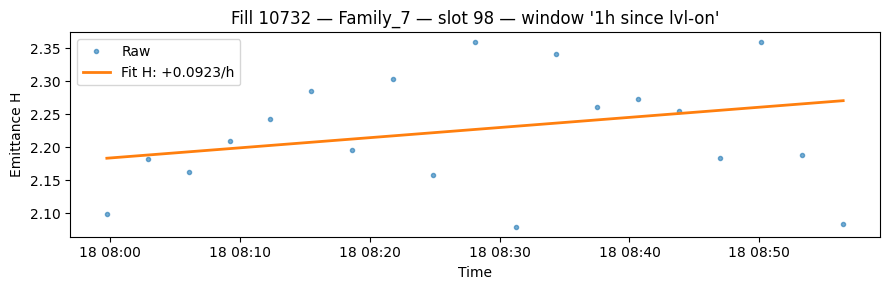

In [11]:
from typing import Optional

# ---------------------------------------------
# Plot one slot for a given STABLE window (raw + fit overlay)
# ---------------------------------------------
def plot_slot_stable_window(
    fno: int,
    family: str,
    beam: str,
    window_label: str,
    plane: str = PLANE_DEFAULT,
    slot: Optional[int] = None,
    figsize: tuple = FIGSIZE_SLOT
):
    """
    Plot the raw emittance and robust fit for a single slot
    in a given family, fill, and STABLE window.
    """
    plane = plane.upper()
    if plane not in ('H','V'):
        raise ValueError("plane must be 'H' or 'V'")

    # Select slots in the family
    fams = build_families_for_fill(fillno=fno, beam=beam, ip=ip, RAWDATA=RAWDATA)
    slots = list(fams.get(family, []))
    if not slots:
        raise RuntimeError(f"No slots for family {family} in fill {fno}.")
    if slot is None:
        slot = int(slots[0])
    elif slot not in slots:
        raise RuntimeError(f"Requested slot {slot} not in family {family}. Available: {slots}")

    # Ensure we have stable fits precomputed
    if fno not in all_win_fits:
        raise RuntimeError(f"No STABLE fits found for fill {fno}.")
    win_dict = all_win_fits[fno]
    if window_label not in win_dict:
        raise RuntimeError(f"Window '{window_label}' not in precomputed STABLE windows for fill {fno}.")
    fam_block = win_dict[window_label].get(family, {})
    tup = fam_block.get((plane, slot))
    if tup is None:
        raise RuntimeError(f"No fit for plane {plane}, slot {slot} in family {family}, window '{window_label}'.")

    # Unpack tuple: either (m, b, t0, series) or (m, b, err, t0, series)
    # Identify by length:
    if len(tup) == 4:
        m, b, t0, ser = tup
    else:
        m, b, _, t0, ser = tup

    # Build fit curve
    xh   = (ser.index - t0).total_seconds()/3600.0
    yfit = b + m*xh

    # Plot
    plt.figure(figsize=figsize)
    plt.plot(ser.index, ser.values, '.', label='Raw', alpha=0.6)
    plt.plot(ser.index, yfit, '-', label=f"Fit {plane}: {m:+.3g}/h", linewidth=2)
    plt.xlabel('Time')
    plt.ylabel(f'Emittance {plane}')
    plt.title(f"Fill {fno} — {family} — slot {slot} — window '{window_label}'")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------------------------
# EXAMPLE usage:
# ---------------------------------------------
EX_FILL      = fills[12]                # or a specific fill number
EX_FAMILY    = 'Family_7'
EX_WINDOW    = list(all_win_fits[EX_FILL].keys())[0]  # pick first window
EX_PLANE     = 'H'
EX_SLOT      = None                   # None => first slot in family

plot_slot_stable_window(
    fno=EX_FILL,
    family=EX_FAMILY,
    beam=beam,
    window_label=EX_WINDOW,
    plane=EX_PLANE,
    slot=EX_SLOT
)


In [12]:
from typing import Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# ---------------------------------------------
# Assumed pre‑existing imports & definitions:
#   fbmodes, RAWDATA, fills, beam, ip
#   build_families_for_fill, all_win_fits
#   load_STABLE_series, extract_slot, leveling_on_time
#   PLANE_DEFAULT, FIGSIZE_SLOT
# ---------------------------------------------

def plot_slot_stable_window(
    fno: int,
    family: str,
    beam: str,
    window_label: str,
    plane: str = PLANE_DEFAULT,
    slot: Optional[int] = None,
    zoom: bool = False,
    zoom_hours: float = 5.0,
    figsize: tuple = FIGSIZE_SLOT
):
    """
    1) Plot raw + fit for a single STABLE window.
    2) Then overlay all STABLE windows in one plot.
       If zoom=True, only show the first `zoom_hours` hours after leveling-on.
    """
    plane = plane.upper()
    if plane not in ('H', 'V'):
        raise ValueError("plane must be 'H' or 'V'")

    # --- pick slot ---
    fams  = build_families_for_fill(fillno=fno, beam=beam, ip=ip, RAWDATA=RAWDATA)
    slots = fams.get(family, [])
    if len(slots) == 0:
        raise RuntimeError(f"No slots for family '{family}' in fill {fno}")
    if slot is None:
        slot = slots[0]
    elif slot not in slots:
        raise RuntimeError(f"Slot {slot} not in family '{family}'. Available: {slots}")

    # --- single-window fit & raw ---
    win_dict = all_win_fits.get(fno, {})
    if window_label not in win_dict:
        raise RuntimeError(f"Window '{window_label}' not precomputed for fill {fno}")
    fam_block = win_dict[window_label].get(family, {})
    tup = fam_block.get((plane, slot))
    if tup is None:
        raise RuntimeError(f"No fit for plane {plane}, slot {slot} in window '{window_label}'")

    # unpack tuple (4‑ or 5‑element)
    if len(tup) == 4:
        m, b, t0, ser = tup
    else:
        m, b, _, t0, ser = tup

    # build fit curve
    xh  = (ser.index - t0).total_seconds() / 3600.0
    yfw = b + m * xh

    # --- Plot 1: single window ---
    plt.figure(figsize=figsize)
    plt.plot(ser.index,   ser.values, '.', alpha=0.6, label='Raw')
    plt.plot(ser.index,   yfw,        '-', lw=2,     label=f"Fit {plane}: {m:+.3g}/h")
    plt.title(f"Fill {fno} · {family} · slot {slot} · '{window_label}'")
    plt.xlabel("Time"); plt.ylabel(f"Emittance {plane}")
    plt.legend(); plt.tight_layout(); plt.show()

    # --- Prepare zoom limits if requested ---
    if zoom:
        t_on     = leveling_on_time(fno)
        t_zoom_h = t_on + pd.Timedelta(hours=zoom_hours)
        xlim = (t_on, t_zoom_h)
    else:
        xlim = None

    # --- Plot 2: all windows overlay ---
    cmap = plt.get_cmap("tab20")
    fig, ax = plt.subplots(figsize=figsize)
    ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))

    for i, (wlabel, wmap) in enumerate(win_dict.items()):
        tup2 = wmap.get(family, {}).get((plane, slot))
        if tup2 is None:
            continue
        # unpack
        if len(tup2) == 4:
            m2, b2, t02, ser2 = tup2
        else:
            m2, b2, _, t02, ser2 = tup2

        # optionally clip to zoom window
        if zoom:
            ser2 = ser2.loc[t_on:t_zoom_h]
            if ser2.empty:
                continue

        color = cmap(i)
        ax.plot(ser2.index, ser2.values, '.', alpha=0.4, color=color)
        xh2  = (ser2.index - t02).total_seconds()/3600.0
        yfw2 = b2 + m2 * xh2
        ax.plot(ser2.index, yfw2, '-', lw=2, color=color,
                label=f"{wlabel} ({m2:+.3g}/h)")

    if xlim:
        ax.set_xlim(*xlim)
    ax.set_title(f"Fill {fno} · {family} · slot {slot} · All STABLE windows")
    ax.set_xlabel("Time"); ax.set_ylabel(f"Emittance {plane}")
    ax.legend(ncol=2, fontsize="small", bbox_to_anchor=(1.01,1))
    fig.tight_layout(); plt.show()


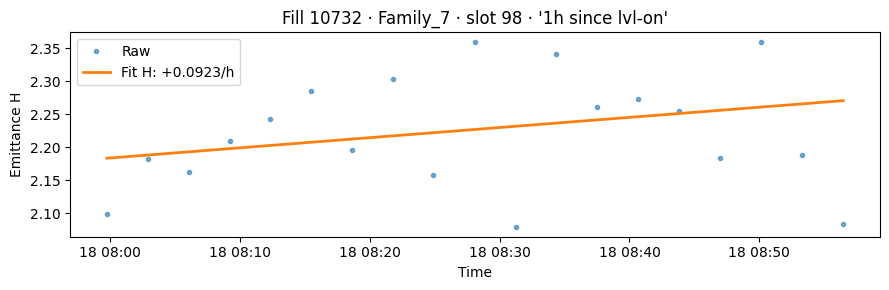

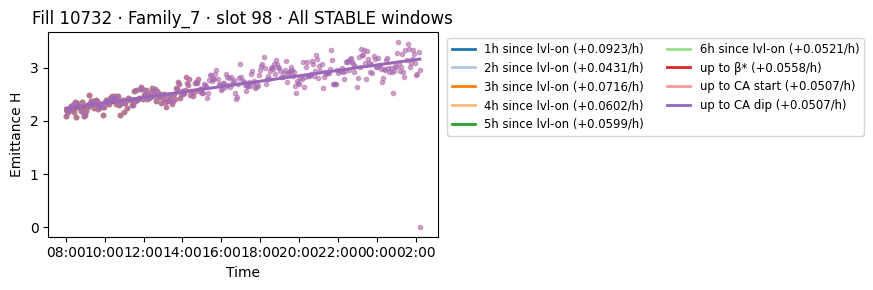

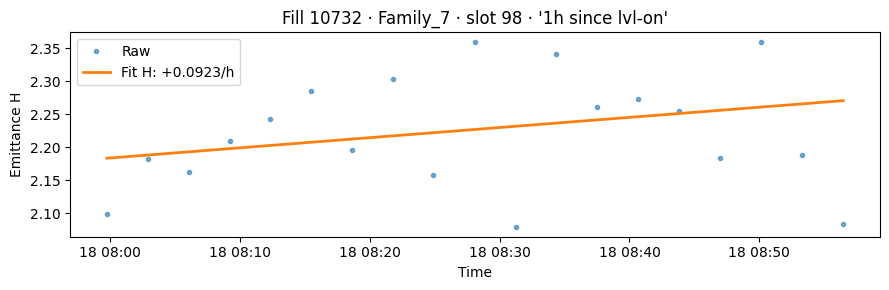

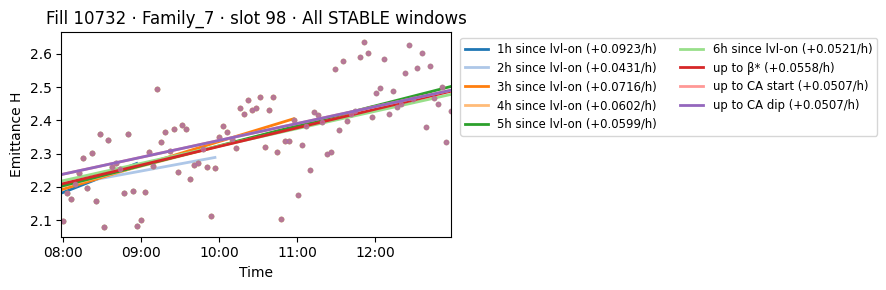

In [13]:
# Single‐window + overlay of all windows, unzoomed
plot_slot_stable_window(
    fno=EX_FILL,
    family=EX_FAMILY,
    beam=beam,
    window_label=EX_WINDOW,
    plane=EX_PLANE,
    slot=EX_SLOT,
    zoom=False
)

# Same, but zoom first 5 hours after leveling-on
plot_slot_stable_window(
    fno=EX_FILL,
    family=EX_FAMILY,
    beam=beam,
    window_label=EX_WINDOW,
    plane=EX_PLANE,
    slot=EX_SLOT,
    zoom=True,
    zoom_hours=5.0
)


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_raw_and_fits_after_leveling(
    fno: int,
    family: str,
    beam: str,
    plane: str = PLANE_DEFAULT,
    slot: Optional[int] = None,
    figsize: tuple = (10,4)
):
    """
    Plot raw STABLE emittance for one slot, zoomed to the first 5 hours after leveling-on,
    plus overlay two robust fits:
      • fit over the first 5 h
      • fit over the first 4 h
    """
    # --- select slot ---
    fams  = build_families_for_fill(fillno=fno, beam=beam, ip=ip, RAWDATA=RAWDATA)
    slots = fams.get(family, [])
    if len(slots) == 0:
        raise RuntimeError(f"No slots for family '{family}' in fill {fno}")
    if slot is None:
        slot = slots[0]
    elif slot not in slots:
        raise RuntimeError(f"Slot {slot} not in family '{family}'. Available: {slots}")

    # --- determine time windows ---
    t_on   = leveling_on_time(fno)
    t_5h   = t_on + pd.Timedelta(hours=5)
    t_4h   = t_on + pd.Timedelta(hours=4)

    # --- load raw STABLE series ---
    bsrt_loc = '5R4' if beam.upper()=='B1' else '5L4'
    pv_name  = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_{plane.upper()}"
    full_ser = load_STABLE_series(pv_name, fno)
    raw_ser  = extract_slot(full_ser, slot).loc[t_on:t_5h].dropna()
    if raw_ser.empty:
        raise RuntimeError("No data in first 5 hours after leveling-on")

    # --- build time‐relative arrays for fitting ---
    x5 = (raw_ser.index - t_on).total_seconds() / 3600.0
    y5 = raw_ser.values

    # fit over 5 h
    m5, b5, err5, _ = robust_line(x5, y5)

    # clip to 4 h
    raw4 = raw_ser.loc[:t_4h]
    x4   = (raw4.index - t_on).total_seconds() / 3600.0
    y4   = raw4.values
    m4, b4, err4, _ = robust_line(x4, y4)

    # --- plot ---
    plt.figure(figsize=figsize)
    # raw data
    plt.plot(raw_ser.index, raw_ser.values, '.', alpha=0.6, label='Raw (0–5 h)')
    # 5 h fit
    yfit5 = b5 + m5 * x5
    plt.plot(raw_ser.index, yfit5, '-', lw=2, label=f"Fit over 5 h: {m5:+.3g}/h")
    # 4 h fit
    yfit4 = b4 + m4 * x5  # extend 4 h fit across 5 h span
    mask5 = x5 <= 4.0
    plt.plot(raw_ser.index[mask5], yfit4[mask5], '--', lw=2, label=f"Fit over 4 h: {m4:+.3g}/h")

    plt.xlim(t_on, t_5h)
    plt.xlabel("Time")
    plt.ylabel(f"Emittance {plane.upper()}")
    plt.title(f"Fill {fno} · {family} · slot {slot} · raw + fits (0–5 h)")
    plt.legend()
    plt.tight_layout()
    plt.show()


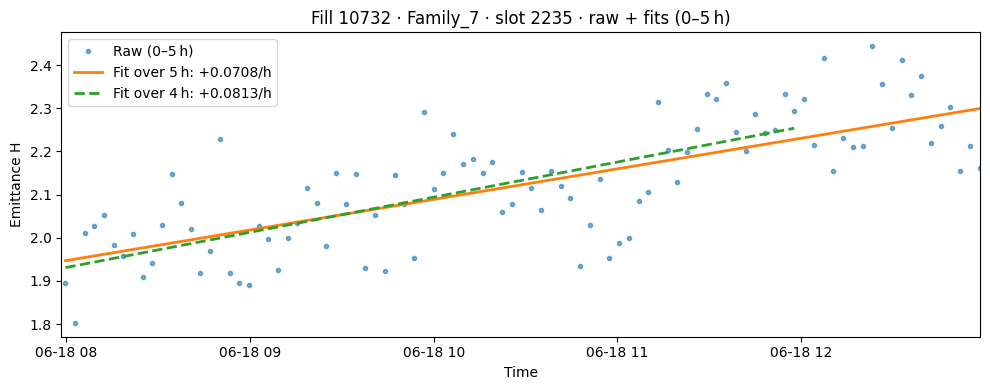

In [15]:
EX_SLOT = 2235
plot_raw_and_fits_after_leveling(
    fno=EX_FILL,
    family=EX_FAMILY,
    beam=beam,
    plane=EX_PLANE,
    slot=EX_SLOT
)


In [16]:
df_stable_windows.head(9)


Family_1_H_rate_mean_w  Family_1_H_err_family  \
fill  window                                                           
10665 1h since lvl-on                0.118322               0.018548   
      2h since lvl-on                0.093376               0.007075   
      3h since lvl-on                0.091524               0.004293   
      4h since lvl-on                0.090366               0.003024   
      up to CA dip                   0.084354               0.001383   
      up to CA start                 0.083522               0.001668   
      up to β*                       0.092484               0.002158   
10666 1h since lvl-on                0.096310               0.020080   
      2h since lvl-on                0.099900               0.007506   

                       Family_1_H_std_slots  Family_1_H_mad_slots  \
fill  window                                                        
10665 1h since lvl-on              0.047044              0.043435   
      2h since lvl-on              0.017598              0.018694   
      3h since lvl-on              0.012487              0.012180   
      4h since lvl-on              0.008568              0.006351   
      up to CA dip                 0.005824              0.004197   
      up to CA start               0.006327              0.004088   
      up to β*                     0.006762              0.005403   
10666 1h since lvl-on              0.050230              0.032506   
      2h since lvl-on              0.018500              0.023133   

                       Family_1_H_n_slots  Family_1_V_rate_mean_w  \
fill  window                                                        
10665 1h since lvl-on                  19                0.051233   
      2h since lvl-on                  19                0.091548   
      3h since lvl-on                  19                0.096800   
      4h since lvl-on                  19                0.098968   
      up to CA dip                     19                0.085129   
      up to CA start                   19                0.085790   
      up to β*                         19                0.098609   
10666 1h since lvl-on                  19                0.060879   
      2h since lvl-on                  19                0.061470   

                       Family_1_V_err_family  Family_1_V_std_slots  \
fill  window                                                         
10665 1h since lvl-on               0.012502              0.026507   
      2h since lvl-on               0.006738              0.011446   
      3h since lvl-on               0.003389              0.009396   
      4h since lvl-on               0.002249              0.007307   
      up to CA dip                  0.000953              0.008562   
      up to CA start                0.001262              0.008449   
      up to β*                      0.001498              0.007134   
10666 1h since lvl-on               0.012245              0.027859   
      2h since lvl-on               0.004968              0.015239   

                       Family_1_V_mad_slots  Family_1_V_n_slots  ...  \
fill  window                                                     ...   
10665 1h since lvl-on              0.029576                  19  ...   
      2h since lvl-on              0.011995                  19  ...   
      3h since lvl-on              0.008285                  19  ...   
      4h since lvl-on              0.006401                  19  ...   
      up to CA dip                 0.005986                  19  ...   
      up to CA start               0.006777                  19  ...   
      up to β*                     0.007489                  19  ...   
10666 1h since lvl-on              0.023300                  19  ...   
      2h since lvl-on              0.016168                  19  ...   

                       Family_8_H_rate_mean_w  Family_8_H_err_family  \
fill  window                                                           
10

## Plots

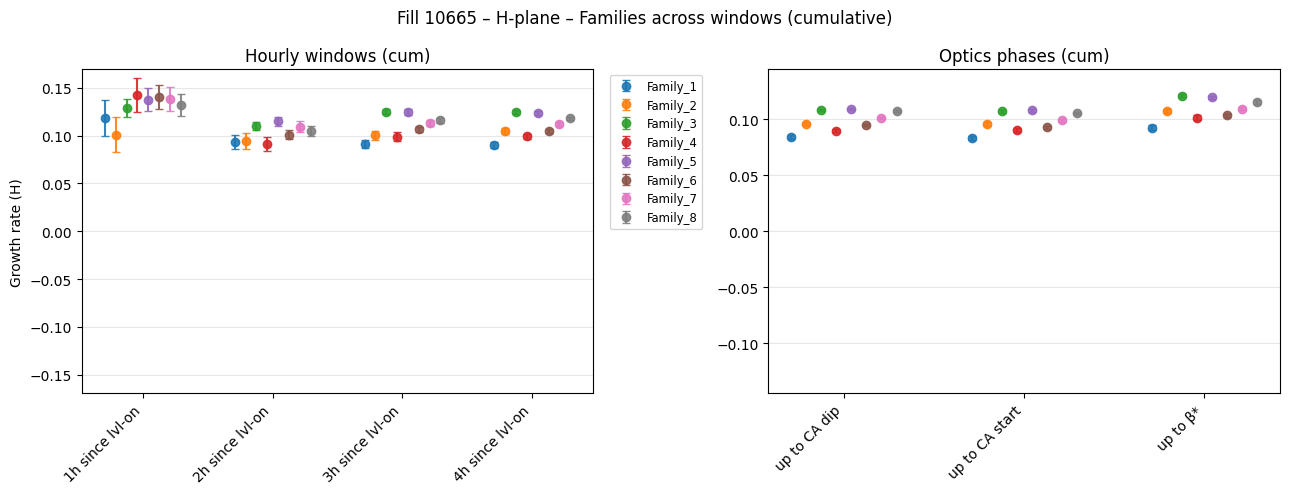

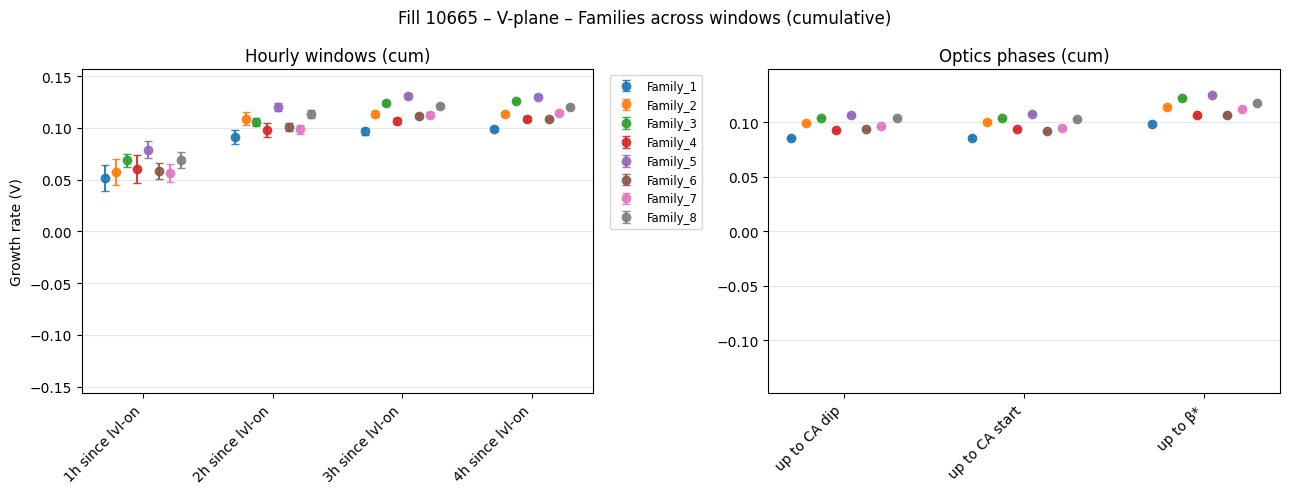

,lvl_on,beta_final,ca_start,ca_dip
10665,2025-05-24 21:19:05.427699+00:00,2025-05-25 02:20:38.845363525+00:00,2025-05-25 04:06:56.553000+00:00,2025-05-25 05:19:48.501000+00:00
10666,2025-05-25 13:00:52.732165+00:00,2025-05-25 18:08:24.201863525+00:00,2025-05-25 20:02:23.501000+00:00,2025-05-25 21:23:41.501000+00:00
10671,2025-05-27 23:13:09.706522+00:00,2025-05-28 04:31:45.916988525+00:00,2025-05-28 06:25:06.501000+00:00,2025-05-28 07:41:24.501000+00:00
10673,2025-05-29 06:36:11.711926+00:00,2025-05-29 11:05:03.604988525+00:00,2025-05-29 05:59:02.150000+00:00,2025-05-29 05:59:11.501000+00:00
10675,2025-05-30 08:56:53.789406+00:00,2025-05-30 12:26:01.175863525+00:00,2025-05-30 13:52:29.501000+00:00,2025-05-30 15:04:57.501000+00:00
10676,2025-05-30 22:42:34.182378+00:00,2025-05-31 05:13:51.543613525+00:00,2025-05-31 07:19:07.735000+00:00,2025-05-31 08:41:57.501000+00:00
10685,2025-06-03 18:38:02.755043+00:00,2025-06-04 00:25:44.739488525+00:00,2025-06-04 02:19:57.501000+00:00,2025-06-04 03:38:50.528000+00:00
10689,2025-06-04 12:21:46.175612+00:00,2025-06-04 18:50:30.149238525+00:00,2025-06-04 20:56:28.501000+00:00,2025-06-04 22:18:16.501000+00:00
10690,2025-06-05 04:17:10.302123+00:00,2025-06-05 10:10:48.497613525+00:00,2025-06-05 12:00:39.501000+00:00,2025-06-05 13:17:19.534000+00:00
10701,2025-06-08 00:11:17.292376+00:00,2025-06-08 05:54:37.002988525+00:00,2025-06-08 07:59:25.501000+00:00,2025-06-08 09:16:59.501000+00:00


In [17]:

# Example:
fno_plot = fills[0]
plot_families_windows_split(df_stable_windows, fno_plot, plane='H', err='sem', err_cap=0.5)
plot_families_windows_split(df_stable_windows, fno_plot, plane='V', err='sem', err_cap=0.3)
df_markers = pd.DataFrame.from_dict(markers_per_fill, orient='index').sort_index()
display(df_markers)


# End of Injection -> start of stable

In [18]:
# ============================================
# BRIDGE: end(INJ) → start(STABLE), two-point rate
# ============================================

def get_inj_end_and_stable_start(fno: int) -> tuple[pd.Timestamp, pd.Timestamp]:
    sub = fbmodes.loc[fno].sort_values('tsStart')
    inj = sub[sub['BMODE'].str.upper() == 'INJPHYS']
    stb = sub[sub['BMODE'].str.upper() == 'STABLE']
    if inj.empty or stb.empty:
        raise RuntimeError(f"Fill {fno}: missing INJPHYS or STABLE section")
    t_inj_end   = pd.to_datetime(inj['tsEnd'  ].iloc[-1], utc=True)
    t_stb_start = pd.to_datetime(stb['tsStart'].iloc[0],   utc=True)
    return t_inj_end, t_stb_start


def eval_fit_at_time(fit_tuple, t_eval: pd.Timestamp) -> float:
    """
    Evaluate y = m*x + b at absolute time t_eval.
    Accepts tuples of shape:
      (m, b, stderr, t0, series)  OR  (m, b, t0, series)
    """
    if fit_tuple is None:
        return np.nan
    try:
        if len(fit_tuple) == 5:
            m, b, _, t0, _ = fit_tuple
        elif len(fit_tuple) == 4:
            m, b, t0, _ = fit_tuple
        else:
            return np.nan
    except Exception:
        return np.nan

    if np.isnan(m) or pd.isna(t0):
        return np.nan

    xh = (t_eval - t0).total_seconds()/3600.0
    return b + m*xh


def bridge_rates_two_point(fno: int,
                           families: dict,
                           inj_fits_dict: dict,
                           stb_win_fits_dict: dict,
                           plane: str = 'H') -> pd.DataFrame:
    """
    inj_fits_dict      = all_fits[fno]          (from INJ analysis)
    stb_win_fits_dict  = all_win_fits[fno]      (from STABLE windows analysis)
    Returns DF indexed by (fill,family) with mean, sd, sem, N for the bridge.
    """
    t_inj_end, t_stb_start = get_inj_end_and_stable_start(fno)
    dt_h = (t_stb_start - t_inj_end).total_seconds()/3600.0
    if dt_h <= 0:
        raise RuntimeError(f"Fill {fno}: non-positive bridge duration ({dt_h:.3f} h)")

    # pick FIRST stable window in chronological order
    # keys are labels, so just take the first in insertion order – you created them that way
    first_win = next(iter(stb_win_fits_dict.keys()))

    out_rows = []
    for fam, slots in families.items():
        rates = []
        for s in slots:
            inj_tup = inj_fits_dict.get(fam, {}).get(s, {}).get(plane)
            stb_tup = stb_win_fits_dict[first_win].get(fam, {}).get((plane, s))

            if inj_tup is None or stb_tup is None:
                continue

            y1 = eval_fit_at_time(inj_tup, t_inj_end)
            y2 = eval_fit_at_time(stb_tup, t_stb_start)

            if np.isnan(y1) or np.isnan(y2):
                continue

            rates.append((y2 - y1) / dt_h)

        if rates:
            rates = np.array(rates, float)
            sd  = rates.std(ddof=1) if rates.size > 1 else np.nan
            sem = sd/np.sqrt(rates.size) if rates.size > 1 else np.nan
            out_rows.append({
                'fill': fno,
                'family': fam,
                f'{plane}_bridge_mean': rates.mean(),
                f'{plane}_bridge_sd'  : sd,
                f'{plane}_bridge_sem' : sem,
                f'{plane}_bridge_N'   : rates.size
            })
        else:
            out_rows.append({
                'fill': fno,
                'family': fam,
                f'{plane}_bridge_mean': np.nan,
                f'{plane}_bridge_sd'  : np.nan,
                f'{plane}_bridge_sem' : np.nan,
                f'{plane}_bridge_N'   : 0
            })

    return pd.DataFrame(out_rows).set_index(['fill','family'])


# -------- run it --------
all_bridge = []
for fno in fills:
    fams = build_families_for_fill(fillno=fno, beam=beam, ip=ip, RAWDATA=RAWDATA)

    df_H = bridge_rates_two_point(fno, fams, all_fits[fno],    all_win_fits[fno], plane='H')
    df_V = bridge_rates_two_point(fno, fams, all_fits[fno],    all_win_fits[fno], plane='V')

    all_bridge.append(df_H.join(df_V, how='outer'))

df_bridge = pd.concat(all_bridge).sort_index()
display(df_bridge)


H_bridge_mean  H_bridge_sd  H_bridge_sem  H_bridge_N  \
fill  family                                                           
10665 Family_1       0.334295     0.092743      0.025722          13   
      Family_2       0.496389     0.082156      0.022786          13   
      Family_3       0.367450     0.075669      0.011037          47   
      Family_4       0.332296     0.071047      0.019705          13   
      Family_5       0.332483     0.070911      0.012161          34   
...                       ...          ...           ...         ...   
10732 Family_4       0.751105     0.076008      0.020314          14   
      Family_5       0.767772     0.084044      0.013817          37   
      Family_6       0.810235     0.067708      0.011131          37   
      Family_7       0.927416     0.089801      0.014763          37   
      Family_8       0.826257     0.085232      0.014012          37   

                V_bridge_mean  V_bridge_sd  V_bridge_sem  V_bridge_N  
fill  family                                                          
10665 Family_1       0.598999     0.055862      0.015493          13  
      Family_2       0.840316     0.106993      0.029674          13  
      Family_3       0.783982     0.094864      0.013837          47  
      Family_4       0.596151     0.048928      0.013570          13  
      Family_5       0.758341     0.091437      0.015681          34  
...                       ...          ...           ...         ...  
10732 Family_4       0.931311     0.052599      0.014058          14  
      Family_5       1.134350     0.082724      0.013600          37  
      Family_6       1.154189     0.083078      0.013658          37  
      Family_7       1.197858     0.070482      0.011587          37  
      Family_8       1.205786     0.076858      0.012635          37  

[112 rows x 8 columns]

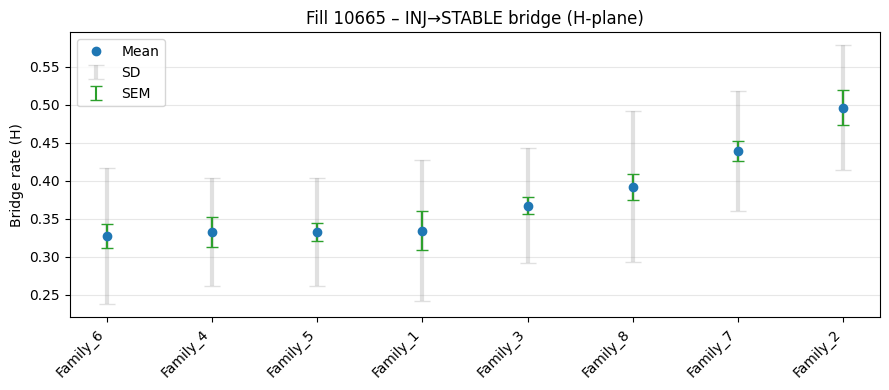

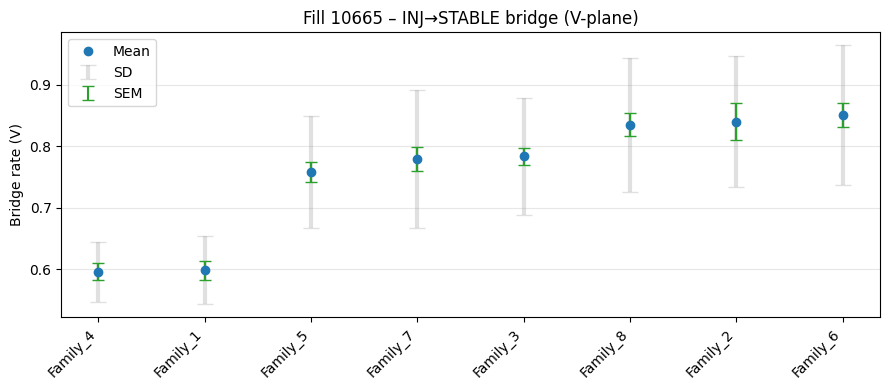

In [19]:
def plot_bridge_mean_sem_sd(df_bridge, fillno, plane='H',
                            figsize=(9,4),
                            mean_color='C0', sem_color='C2', sd_color='0.6'):
    mean_col = f'{plane}_bridge_mean'
    sd_col   = f'{plane}_bridge_sd'
    sem_col  = f'{plane}_bridge_sem'

    row = df_bridge.xs(fillno, level='fill').dropna(subset=[mean_col], how='all')
    fams  = row.index.astype(str)
    means = row[mean_col].to_numpy()
    sd    = row[sd_col].to_numpy()
    sem   = row[sem_col].to_numpy()

    order = np.argsort(means)
    fams, means, sd, sem = fams[order], means[order], sd[order], sem[order]
    x = np.arange(len(fams))

    plt.figure(figsize=figsize)
    plt.errorbar(x, means, yerr=sd, fmt='none', lw=3, alpha=0.3,
                 ecolor=sd_color, capsize=6, label='SD')
    plt.errorbar(x, means, yerr=sem, fmt='none', lw=1.5,
                 ecolor=sem_color, capsize=4, label='SEM')
    plt.plot(x, means, 'o', ms=6, color=mean_color, label='Mean')

    plt.xticks(x, fams, rotation=45, ha='right')
    plt.ylabel(f'Bridge rate ({plane})')
    plt.title(f'Fill {fillno} – INJ→STABLE bridge ({plane}-plane)')
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example
fill_plot = fills[0]
plot_bridge_mean_sem_sd(df_bridge, fill_plot, plane='H')
plot_bridge_mean_sem_sd(df_bridge, fill_plot, plane='V')


In [20]:
from typing import Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
def eval_fit_curve(fit_tuple, times: pd.DatetimeIndex) -> np.ndarray:
    """Evaluate y = b + m * ((times - t0)/3600h)."""
    if fit_tuple is None:
        return np.full(len(times), np.nan)
    if len(fit_tuple) == 5:
        m, b, _, t0, _ = fit_tuple
    else:
        m, b, t0, _ = fit_tuple
    dt_h = (times - t0).total_seconds() / 3600.0
    return b + m * dt_h

def plot_full_pipeline_for_slot(
    fno: int,
    family: str,
    beam: str,
    plane: str = 'H',
    slot: Optional[int] = None,
    figsize=(12,5),
    zoom: bool = False
):
    plane = plane.upper()
    fams  = build_families_for_fill(fillno=fno, beam=beam, ip=ip, RAWDATA=RAWDATA)
    slots = list(fams.get(family, []))
    if not slots:
        raise RuntimeError(f"No slots in family '{family}' for fill {fno}")
    slot = slots[0] if slot is None else slot
    if slot not in slots:
        raise RuntimeError(f"Slot {slot} not in family '{family}'")

    # 1) full raw series
    bsrt_loc  = '5R4' if beam.upper()=='B1' else '5L4'
    PV        = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_{plane}"
    full_bsrt = load_series(PV, fno, RAWDATA).sort_index()
    raw_full  = extract_slot(full_bsrt, slot).dropna()

    # 2) injection raw + fit
    inj_tup      = all_fits[fno][family][slot][plane]
    ser_inj      = inj_tup[-1]
    inj_fit_vals = eval_fit_curve(inj_tup, ser_inj.index)

    # 3) markers
    modes       = fbmodes.loc[fno].sort_values('tsStart')
    t_on        = leveling_on_time(fno)

    # 4) bridge & stable raw subsets
    t_end_inj   = ser_inj.index.min()  # start of injection
    raw_bridge  = raw_full[(raw_full.index >= t_end_inj) & (raw_full.index < t_on)]
    raw_stable  = raw_full[ raw_full.index >= t_on ]

    # 5) stable fit
    first_win    = next(iter(all_win_fits[fno]))
    stab_tup     = all_win_fits[fno][first_win][family][(plane, slot)]
    stab_fit_vals= eval_fit_curve(stab_tup, raw_stable.index)

    # 6) plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))

    ax.plot(raw_full.index, raw_full.values, '.', c='lightgray', alpha=0.6, label='Raw (full fill)')
    ax.plot(ser_inj.index, ser_inj.values, 'o', c='tab:blue',   alpha=0.7, label='Injection raw')
    ax.plot(ser_inj.index, inj_fit_vals,   '-', c='tab:blue',   lw=2,      label=f'Injection fit {plane}')
    ax.plot(raw_bridge.index, raw_bridge.values, 'o', c='tab:orange', alpha=0.7, label='Bridge raw')
    ax.plot(raw_stable.index, raw_stable.values, 'o', c='tab:green',  alpha=0.7, label='Stable raw')
    ax.plot(raw_stable.index, stab_fit_vals,      '--',c='tab:green',  lw=2,      label=f'Stable fit {plane}')

    if zoom:
        start_zoom = ser_inj.index.min()
        end_zoom   = t_on + pd.Timedelta(hours=1)
        ax.set_xlim(start_zoom, end_zoom)

    ax.set_title(f"Fill {fno} — {family} — slot {slot} — {plane}-plane overview")
    ax.set_xlabel("Time"); ax.set_ylabel("Emittance")
    ax.grid(alpha=0.3)
    ax.legend(loc='upper left', ncol=2)
    fig.tight_layout()
    plt.show()



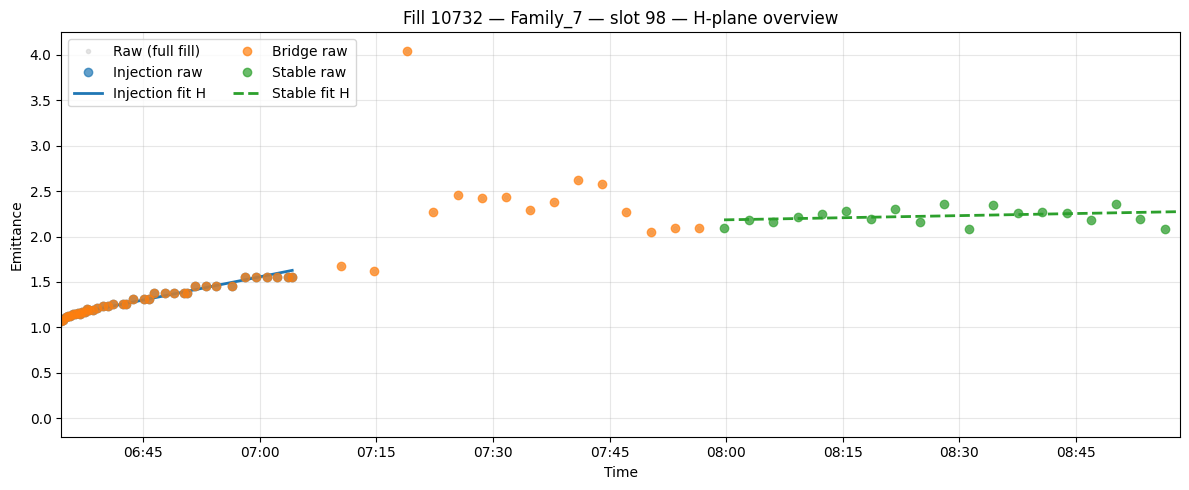

In [21]:
plot_full_pipeline_for_slot(
    fno=10732,
    family='Family_7',
    beam='B1',
    plane='H',
    zoom=True
)



# Average over all fills

In [22]:
import numpy as np
import pandas as pd

# -------------------------------------------------
# Helpers
# -------------------------------------------------
def invvar_weights(err_series):
    """Return 1/err^2, but 0 if err is nan or <=0."""
    w = 1.0 / np.square(err_series)
    w[~np.isfinite(w)] = 0.0
    return w

def weighted_mean_and_sem(vals, errs):
    """
    vals, errs: 1D arrays (may contain NaN).
    Returns mean_w, sem_w, n_eff.
    If no finite weights -> simple mean/std error.
    """
    vals = np.asarray(vals, float)
    errs = np.asarray(errs, float)

    okv = np.isfinite(vals)
    oke = np.isfinite(errs) & (errs > 0)

    if okv.sum() == 0:
        return np.nan, np.nan, 0

    if (okv & oke).sum() == 0:
        # no usable errs, fall back to unweighted
        v = vals[okv]
        m = np.nanmean(v)
        s = np.nanstd(v, ddof=1) if v.size > 1 else np.nan
        sem = s/np.sqrt(v.size) if v.size > 1 else np.nan
        return m, sem, okv.sum()

    # weighted on the subset with both val & err
    mask = okv & oke
    v = vals[mask]; e = errs[mask]
    w = 1.0 / e**2
    m = np.sum(w*v) / np.sum(w)
    sem = (1.0/np.sum(w))**0.5
    n_eff = mask.sum()
    return m, sem, n_eff

def agg_by_family(df, rate_col_prefix, err_col_prefix, extra_cols=None):
    """
    df indexed by ['fill','family'] (or has those columns).
    rate_col_prefix: 'H_rate_mean_w' etc. (no plane part)
    err_col_prefix : 'H_err_family' etc.
    Returns dataframe indexed by family with mean & sem columns.
    """
    if 'fill' not in df.index.names:
        df = df.set_index(['fill','family'])
    fam_out = []
    families = df.index.get_level_values('family').unique()
    for fam in families:
        sub = df.xs(fam, level='family')
        row = {'family': fam}
        for plane in ('H','V'):
            rcol = f"{plane}_{rate_col_prefix}"
            ecol = f"{plane}_{err_col_prefix}"
            if rcol in sub.columns:
                m, sem, n_eff = weighted_mean_and_sem(sub[rcol].values,
                                                      sub[ecol].values if ecol in sub else np.full(len(sub), np.nan))
                row[f"{plane}_mean"] = m
                row[f"{plane}_sem"]  = sem
                row[f"{plane}_Nfills"] = n_eff
        if extra_cols:
            for c in extra_cols:
                if c in sub.columns:
                    row[c] = np.nanmean(sub[c].values)
        fam_out.append(row)
    return (pd.DataFrame(fam_out)
              .set_index('family')
              .sort_index())

def agg_stable(df_stable):
    """
    df_stable indexed by ['fill','window'].
    Columns like 'Family_1_H_rate_mean_w', 'Family_1_H_err_family', ...
    We average over fills for each (window,family,plane).
    Returns a wide DF: index window, columns MultiIndex (family, plane, metric).
    """
    if 'fill' not in df_stable.index.names:
        df_stable = df_stable.set_index(['fill','window'])
    windows = df_stable.index.get_level_values('window').unique()
    families = sorted({c.split('_H_rate_mean_w')[0] for c in df_stable.columns if c.endswith('_H_rate_mean_w')})
    planes = ('H','V')
    metrics = ('mean','sem','Nfills')

    out = {}
    for w in windows:
        sub = df_stable.xs(w, level='window')
        row_dict = {}
        for fam in families:
            for pl in planes:
                rcol = f"{fam}_{pl}_rate_mean_w"
                ecol = f"{fam}_{pl}_err_family"
                if rcol in sub.columns:
                    m, sem, n_eff = weighted_mean_and_sem(sub[rcol].values,
                                                          sub[ecol].values if ecol in sub else np.full(len(sub), np.nan))
                else:
                    m, sem, n_eff = np.nan, np.nan, 0
                row_dict[(fam, pl, 'mean')]   = m
                row_dict[(fam, pl, 'sem')]    = sem
                row_dict[(fam, pl, 'Nfills')] = n_eff
        out[w] = row_dict

    df_out = pd.DataFrame.from_dict(out, orient='index')
    df_out.columns = pd.MultiIndex.from_tuples(df_out.columns, names=['family','plane','stat'])
    return df_out.sort_index()

def agg_bridge(df_bridge):
    """
    df_bridge indexed by ['fill','family'].
    Columns like H_bridge_mean, H_bridge_sem, V_bridge_mean, V_bridge_sem.
    """
    return agg_by_family(df_bridge,
                         rate_col_prefix='bridge_mean',
                         err_col_prefix='bridge_sem')

# -------------------------------------------------
# RUN AGGREGATIONS
# -------------------------------------------------

# --- Injection phase ---
inj_avg = agg_by_family(df_inj_rates, rate_col_prefix='rate_mean_w', err_col_prefix='err_family')

# If your variable is called df_inj_rates_rob, just rename:
# inj_avg = agg_by_family(df_inj_rates_rob, 'rate_mean_w', 'err_family')

# --- Stable phase (per window) ---
stable_avg = agg_stable(df_stable_windows)

# --- Bridge phase ---
bridge_avg = agg_bridge(df_bridge)

# -------------------------------------------------
# Show / save
# -------------------------------------------------
display(inj_avg)
display(stable_avg)   # MultiIndex columns
display(bridge_avg)

# Example: pick H-plane means for Family_3 across windows
# stable_avg.xs(('Family_3','H','mean'), axis=1)


,H_mean,H_sem,H_Nfills,V_mean,V_sem,V_Nfills
family,,,,,,
Family_1,0.657001,0.005759,13,0.105965,0.001527,13
Family_2,0.734340,0.006517,13,0.400837,0.004009,13
Family_3,0.897733,0.004164,13,0.173671,0.001098,13
Family_4,0.731121,0.006177,13,0.137477,0.001696,13
Family_5,0.951348,0.005199,13,0.235612,0.001427,13
Family_6,0.952976,0.005170,13,0.044313,0.000704,13
Family_7,1.044637,0.005956,13,0.419691,0.002371,13
Family_8,0.899396,0.004886,13,0.167259,0.001483,13


family           Family_1                                              \
plane                   H                          V                    
stat                 mean       sem Nfills      mean       sem Nfills   
1h since lvl-on  0.065148  0.007076     14  0.048611  0.004342     14   
2h since lvl-on  0.071593  0.002814     14  0.061098  0.001757     14   
3h since lvl-on  0.065053  0.001640     13  0.063683  0.001075     13   
4h since lvl-on  0.063964  0.001211     12  0.066917  0.000758     12   
5h since lvl-on  0.055826  0.001532      5  0.061137  0.000913      5   
6h since lvl-on  0.077616  0.003548      1  0.071220  0.001966      1   
up to CA dip     0.059249  0.000432     13  0.056387  0.000277     13   
up to CA start   0.059063  0.000512     13  0.055870  0.000340     13   
up to β*         0.062888  0.000704     14  0.064080  0.000435     14   

family           Family_2                             ... Family_7            \
plane                   H                          V  ...        H         V   
stat                 mean       sem Nfills      mean  ...   Nfills      mean   
1h since lvl-on  0.071516  0.007256     14  0.064851  ...       14  0.038678   
2h since lvl-on  0.076633  0.002906     14  0.071738  ...       14  0.050512   
3h since lvl-on  0.073433  0.001727     13  0.077157  ...       13  0.059621   
4h since lvl-on  0.075455  0.001239     12  0.081522  ...       12  0.062609   
5h since lvl-on  0.065481  0.001538      5  0.072632  ...        5  0.051527   
6h since lvl-on  0.082197  0.003622      1  0.079200  ...        1  0.064033   
up to CA dip     0.072827  0.000447     13  0.070644  ...       13  0.055510   
up to CA start   0.072586  0.000540     13  0.070145  ...       13  0.052652   
up to β*         0.075307  0.000723     14  0.077518  ...       14  0.059374   

family                            Family_8                             \
plane                                    H                          V   
stat                  sem Nfills      mean       sem Nfills      mean   
1h since lvl-on  0.003075     14  0.065660  0.004525     14  0.048352   
2h since lvl-on  0.001244     14  0.070306  0.001826     14  0.063307   
3h since lvl-on  0.000757     13  0.070328  0.001100     13  0.069499   
4h since lvl-on  0.000534     12  0.070983  0.000786     12  0.072022   
5h since lvl-on  0.000664      5  0.058044  0.000983      5  0.060207   
6h since lvl-on  0.001384      1  0.076769  0.002548      1  0.070090   
up to CA dip     0.000198     13  0.069945  0.000286     13  0.061585   
up to CA start   0.000237     13  0.068393  0.000339     13  0.060176   
up to β*         0.000308     14  0.070984  0.000456     14  0.067536   

family                            
plane                             
stat                  sem Nfills  
1h since lvl-on  0.002941     14  
2h since lvl-on  0.001160     14  
3h since lvl-on  0.000706     13  
4h since lvl-on  0.000495     12  
5h since lvl-on  0.000606      5  
6h since lvl-on  0.001390      1  
up to CA dip     0.000186     13  
up to CA start   0.000226     13  
up to β*         0.000289     14  

[9 rows x 48 columns]

,H_mean,H_sem,H_Nfills,V_mean,V_sem,V_Nfills
family,,,,,,
Family_1,0.469515,0.008601,13,0.781901,0.005532,13
Family_2,0.643146,0.008498,13,0.961867,0.009988,13
Family_3,0.552232,0.004518,13,0.926429,0.004186,13
Family_4,0.462841,0.007611,13,0.741633,0.004651,13
Family_5,0.511571,0.005004,13,0.915923,0.004727,13
Family_6,0.571438,0.005371,13,0.969073,0.005121,13
Family_7,0.652204,0.005535,13,1.007598,0.005048,13
Family_8,0.608236,0.005065,13,0.991689,0.004847,13


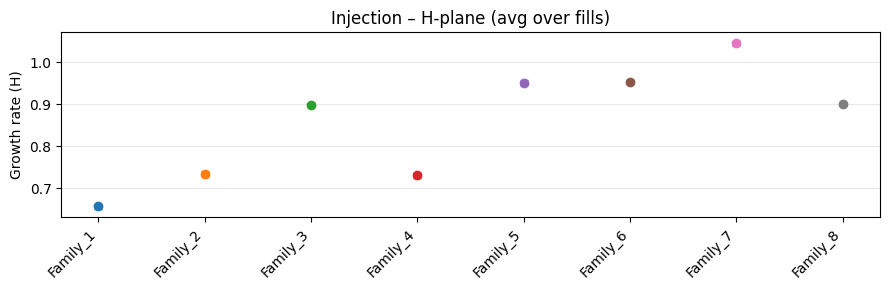

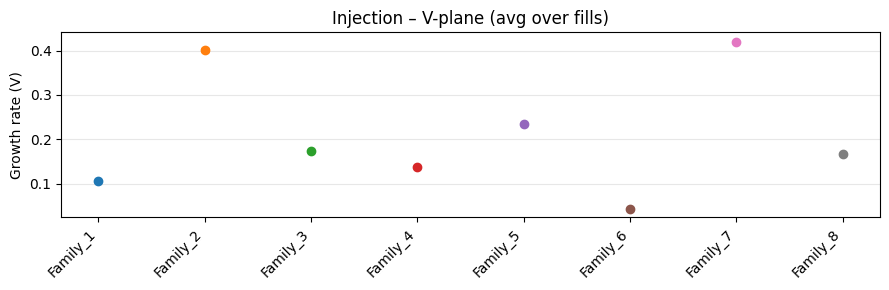

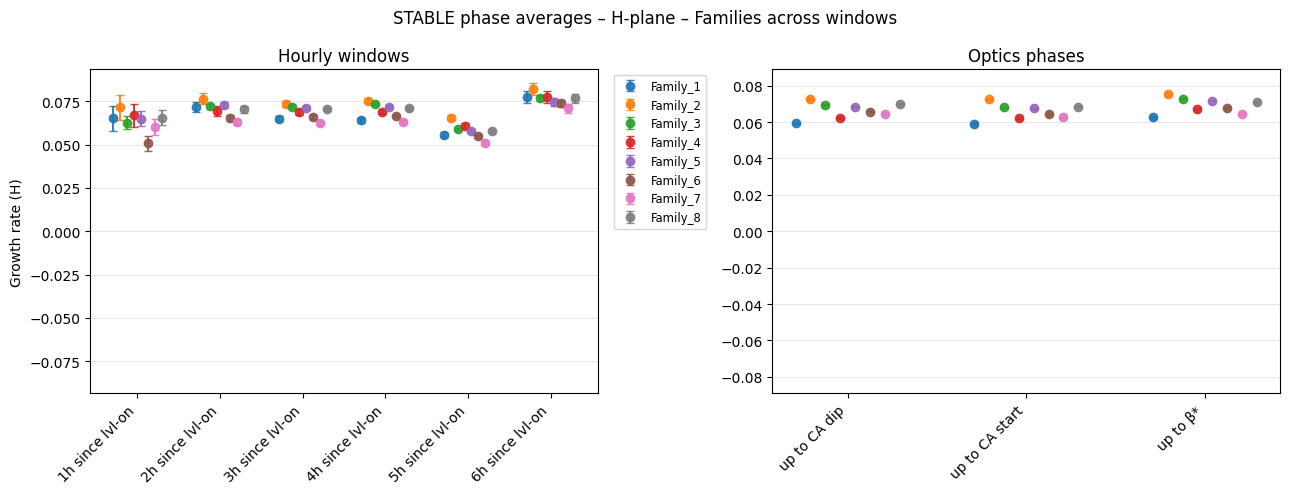

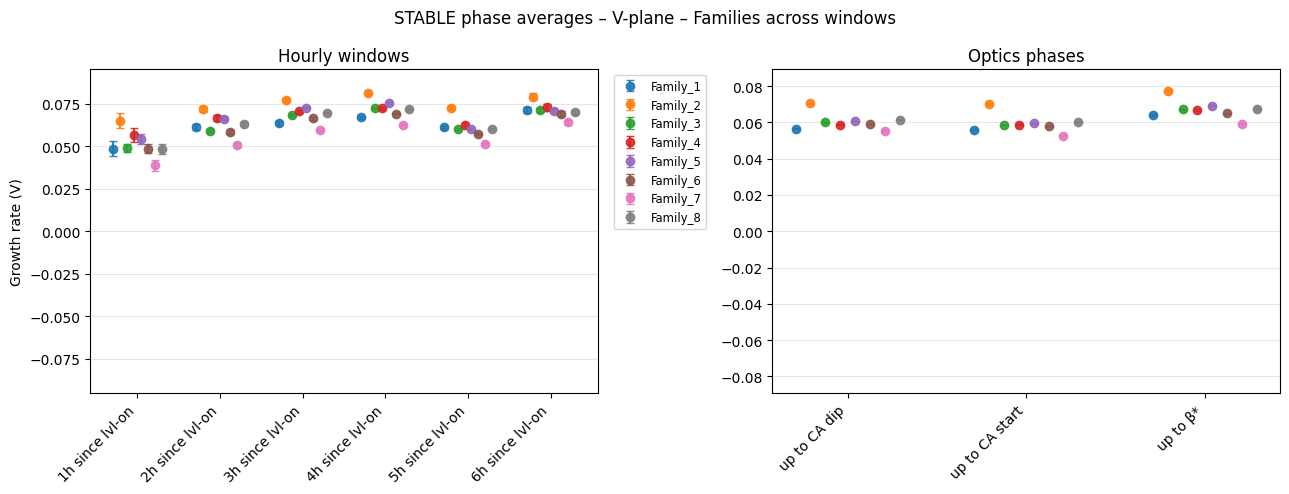

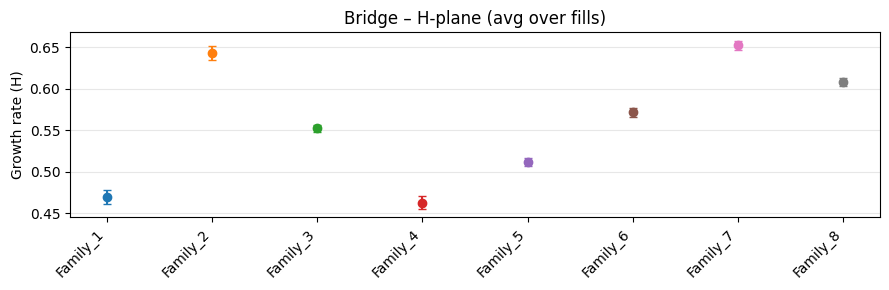

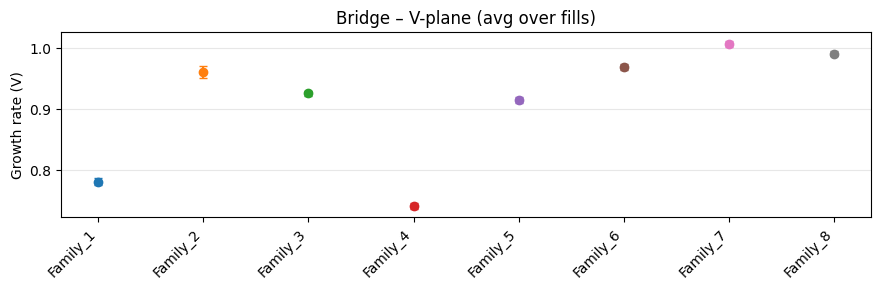

In [23]:
# -------------------------------------------------
# Common styling
# -------------------------------------------------
FAMILY_COLORS = {
    'Family_1': '#1f77b4',
    'Family_2': '#ff7f0e',
    'Family_3': '#2ca02c',
    'Family_4': '#d62728',
    'Family_5': '#9467bd',
    'Family_6': '#8c564b',
    'Family_7': '#e377c2',
    'Family_8': '#7f7f7f',
}

def _err_from(df, plane, kind='sem'):
    if kind != 'sem':
        raise ValueError("Only 'sem' supported here.")
    return df[f'{plane}_sem'].to_numpy()

# -------------------------------------------------
# Injection / Bridge (points + error bars)
# -------------------------------------------------
def plot_phase_family_points(avg_df, phase_name='Injection',
                             plane='H', err='sem', figsize=(9,3)):
    fams  = avg_df.index.tolist()
    means = avg_df[f'{plane}_mean'].to_numpy()
    yerr  = _err_from(avg_df, plane, err)

    x = np.arange(len(fams))
    colors = [FAMILY_COLORS.get(f, None) for f in fams]

    fig, ax = plt.subplots(figsize=figsize)
    ax.errorbar(x, means, yerr=yerr, fmt='o', ms=6, capsize=3,
                linestyle='none', color='k', ecolor='k', alpha=0.0)  # invisible base
    for xi, m, e, c in zip(x, means, yerr, colors):
        ax.errorbar([xi], [m], yerr=[e], fmt='o', ms=6, capsize=3,
                    color=c, ecolor=c, linestyle='none')

    ax.set_xticks(x)
    ax.set_xticklabels(fams, rotation=45, ha='right')
    ax.set_ylabel(f'Growth rate ({plane})')
    ax.set_title(f'{phase_name} – {plane}-plane (avg over fills)')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# Stable windows (split hourly vs optics windows)
# -------------------------------------------------
def split_windows_names(stable_avg):
    hourly = [w for w in stable_avg.index if 'h since' in w]
    optics = [w for w in stable_avg.index if w not in hourly]
    return hourly, optics

def plot_stable_avg_split(stable_avg, plane='H', err='sem',
                          group_spacing=1.2, family_spread=0.7,
                          figsize=(13,5)):
    hourly, optics = split_windows_names(stable_avg)
    fams = sorted({f for f, pl, stat in stable_avg.columns if pl == plane})

    offsets = (np.linspace(-family_spread/2, family_spread/2, len(fams))
               if len(fams) > 1 else np.array([0.0]))

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False)

    for ax, windows, title in zip(
            axes,
            [hourly,   optics],
            ['Hourly windows', 'Optics phases']):
        base_x = np.arange(len(windows)) * group_spacing
        y_all = []

        for i, fam in enumerate(fams):
            mcol = (fam, plane, 'mean')
            ecol = (fam, plane, 'sem')

            y    = stable_avg.loc[windows, mcol].to_numpy()
            yerr = stable_avg.loc[windows, ecol].to_numpy()

            mask = np.isfinite(y)
            x = (base_x + offsets[i])[mask]
            y = y[mask]
            yerr = yerr[mask]

            if y.size == 0:
                continue

            color = FAMILY_COLORS.get(fam)
            ax.errorbar(x, y, yerr=yerr,
                        fmt='o', ms=6, capsize=3,
                        linestyle='none', color=color, ecolor=color,
                        alpha=0.9, label=fam if ax is axes[0] else None)
            y_all.append(y)

        ax.set_xticks(base_x)
        ax.set_xticklabels(windows, rotation=45, ha='right')
        ax.set_title(title)
        ax.grid(axis='y', alpha=0.3)

        if y_all:
            yy = np.concatenate([v for v in y_all if v.size])
            if yy.size:
                rng = np.nanpercentile(np.abs(yy), 98)
                ax.set_ylim(-1.2*rng, 1.2*rng)

    axes[0].set_ylabel(f'Growth rate ({plane})')
    fig.suptitle(f'STABLE phase averages – {plane}-plane – Families across windows')
    axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
    fig.tight_layout()
    plt.show()

# -------------------------------------------------
# Calls (replace inj_avg, stable_avg, bridge_avg with your dfs)
# -------------------------------------------------
plot_phase_family_points(inj_avg,    phase_name='Injection', plane='H')
plot_phase_family_points(inj_avg,    phase_name='Injection', plane='V')

plot_stable_avg_split(stable_avg,    plane='H')
plot_stable_avg_split(stable_avg,    plane='V')

plot_phase_family_points(bridge_avg, phase_name='Bridge',    plane='H')
plot_phase_family_points(bridge_avg, phase_name='Bridge',    plane='V')


In [24]:
# ---------- helpers ----------
FAMILY_COLORS = {
    'Family_1': '#1f77b4','Family_2': '#ff7f0e','Family_3': '#2ca02c','Family_4': '#d62728',
    'Family_5': '#9467bd','Family_6': '#8c564b','Family_7': '#e377c2','Family_8': '#7f7f7f',
}

def split_windows_names(stable_avg):
    hourly = [w for w in stable_avg.index if 'h since' in w]
    # force optics order
    optics_order = ['up to β*', 'up to CA start', 'up to CA dip']
    optics = [w for w in optics_order if w in stable_avg.index]
    return hourly, optics

def common_ylim_for_stable(stable_avg, plane, pad=0.12):
    cols = [c for c in stable_avg.columns if c[1]==plane and c[2]=='mean']
    vals = stable_avg[cols].to_numpy().ravel()
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return None
    lo, hi = np.nanmin(vals), np.nanmax(vals)
    span = hi - lo if hi>lo else 1.0
    return lo - pad*span, hi + pad*span

def draw_mean_band(ax, data, frac=0.25, color='k', alpha=0.08):
    m = np.nanmean(data)
    band = frac * abs(m)
    ax.axhline(m, color=color, lw=1.2, alpha=0.35)
    ax.axhspan(m-band, m+band, color=color, alpha=alpha, zorder=0)

# ---------- main plot ----------
def plot_stable_avg_split_lines(stable_avg, plane='H',
                                group_spacing=1.2, family_spread=0.7,
                                pct_band=0.25, figsize=(13,5)):
    hourly, optics = split_windows_names(stable_avg)
    fams = sorted({f for f, pl, stat in stable_avg.columns if pl==plane})

    offsets = offsets = np.zeros(len(fams))

    # global y-limits (same vertical scale for both panels)
    ylim = common_ylim_for_stable(stable_avg, plane)

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    for ax, windows, title in zip(
            axes,
            [hourly, optics],
            ['Hourly windows', 'Optics phases (up to β*, up to CA start, up to CA dip)']):
        base_x = np.arange(len(windows)) * group_spacing
        all_means = []

        for i, fam in enumerate(fams):
            mcol = (fam, plane, 'mean')
            ecol = (fam, plane, 'sem')
            y    = stable_avg.loc[windows, mcol].to_numpy()
            yerr = stable_avg.loc[windows, ecol].to_numpy()
            x    = base_x 

            color = FAMILY_COLORS.get(fam)
            ax.plot(x, y, '-', lw=1.4, color=color, alpha=0.85)
            ax.errorbar(x, y, yerr=yerr, fmt='o', ms=5, capsize=2,
                        linestyle='none', color=color, ecolor=color,
                        alpha=0.9, label=fam if ax is axes[0] else None)
            all_means.append(y)

        # mean ±25% band for this panel
        yy = np.concatenate([v[np.isfinite(v)] for v in all_means]) if all_means else np.array([])
        if yy.size:
            draw_mean_band(ax, yy, frac=pct_band)

        ax.set_xticks(base_x)
        ax.set_xticklabels(windows, rotation=45, ha='right')
        ax.set_title(title)
        ax.grid(axis='y', alpha=0.3)
        if ylim: ax.set_ylim(*ylim)

    axes[0].set_ylabel(f'Growth rate ({plane})')
    axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
    fig.suptitle(f'STABLE averages – {plane}-plane – Families across windows')
    fig.tight_layout()
    plt.show()


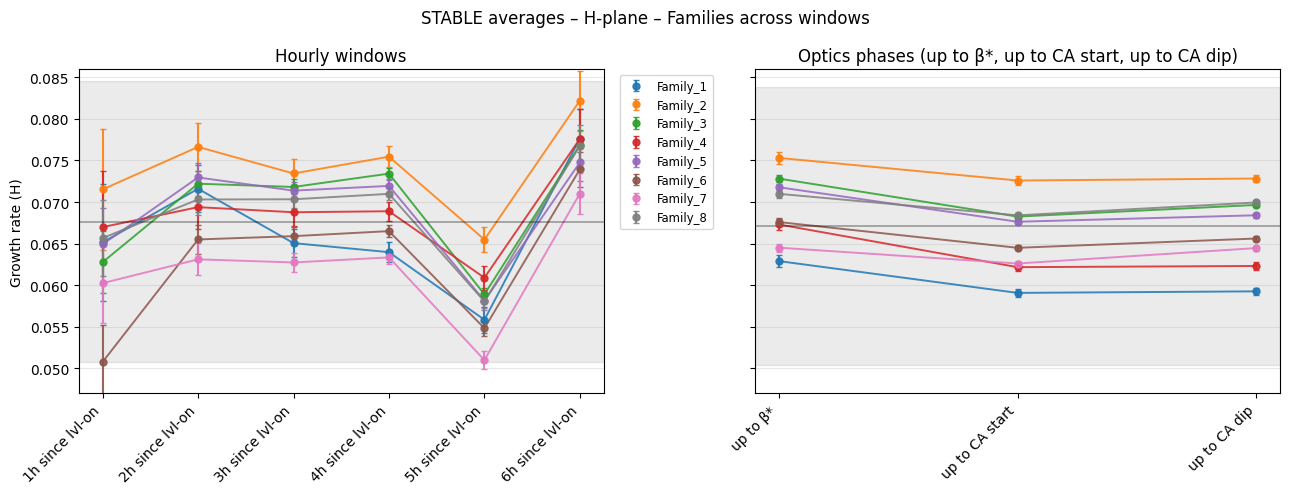

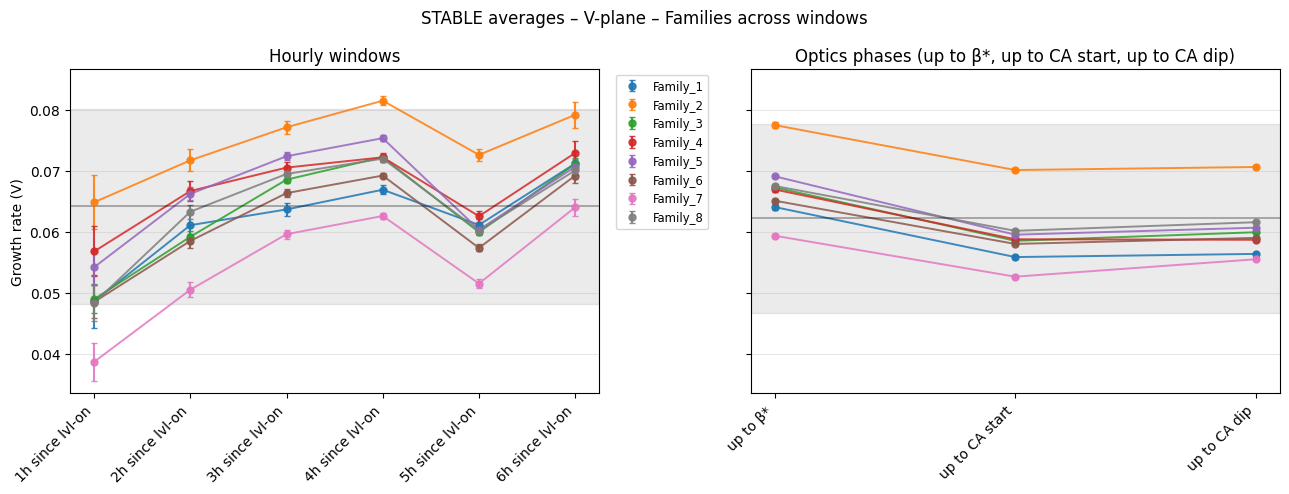

In [25]:
plot_stable_avg_split_lines(stable_avg, plane='H')
plot_stable_avg_split_lines(stable_avg, plane='V')


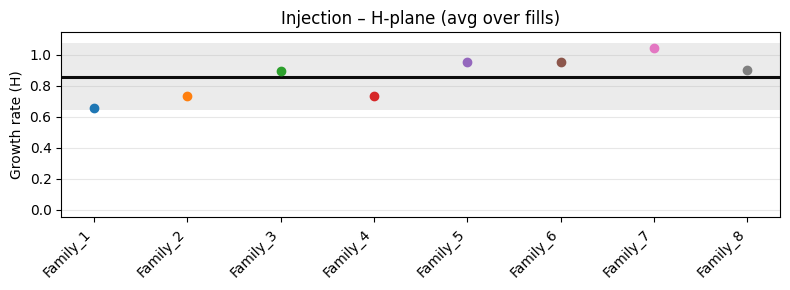

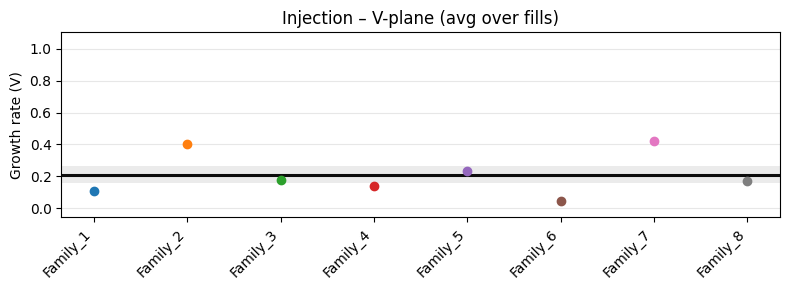

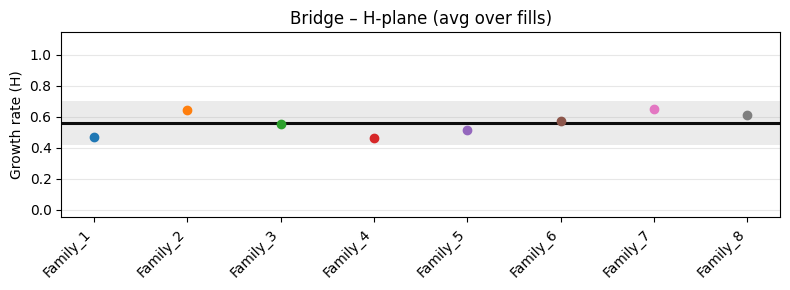

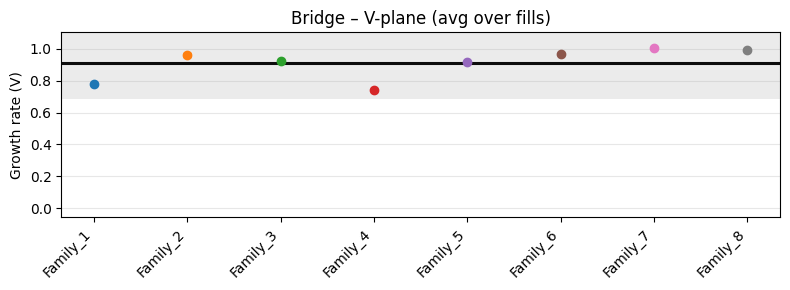

In [26]:
# -------------------- colors --------------------
FAMILY_COLORS = {
    'Family_1': '#1f77b4', 'Family_2': '#ff7f0e', 'Family_3': '#2ca02c',
    'Family_4': '#d62728', 'Family_5': '#9467bd', 'Family_6': '#8c564b',
    'Family_7': '#e377c2', 'Family_8': '#7f7f7f',
}

# -------------------- column finders --------------------
def _find_mean_err_cols(df, plane):
    """
    Return (mean_col, err_col) for a flat DF and given plane.
    Tries the common name patterns used in your tables.
    """
    cols = df.columns
    patterns = [
        (f'{plane}_mean',        f'{plane}_sem'),
        (f'{plane}_rate_mean_w', f'{plane}_err_family'),
        (f'{plane}_bridge_mean', f'{plane}_bridge_sem'),
    ]
    for m, e in patterns:
        if m in cols:
            return m, (e if e in cols else None)
    raise KeyError(f"No mean column for plane={plane} in {list(cols)}")

def _err_sem(df, plane):
    _, err_col = _find_mean_err_cols(df, plane)
    return df[err_col].to_numpy() if err_col else np.full(len(df), np.nan)

def compute_common_ylim(dfs, plane, pad=0.1):
    """
    dfs: list of dfs (can be flat or MultiIndex 'stable_avg').
    Returns a (ymin,ymax) tuple with padding.
    """
    vals = []
    for d in dfs:
        if isinstance(d.columns, pd.MultiIndex):
            cols = [c for c in d.columns if c[1] == plane and c[2] == 'mean']
            if cols:
                vals.append(d[cols].to_numpy().ravel())
        else:
            try:
                mcol, _ = _find_mean_err_cols(d, plane)
                vals.append(d[mcol].to_numpy())
            except KeyError:
                pass

    if not vals:
        return (0, 1)
    vals = np.concatenate(vals)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return (0, 1)
    vmin, vmax = vals.min(), vals.max()
    rng = vmax - vmin if vmax > vmin else 1.0
    return vmin - pad*rng, vmax + pad*rng

# -------------------- mean line + band --------------------
def draw_mean_band_rel(ax, values, frac=0.25,
                       line_color='k', band_color='k',
                       line_kw=None, band_kw=None):
    """
    Draw a bold mean line and a ±frac band around that mean (relative).
    If |mean| ~ 0, fallback to frac * data span.
    """
    vals = np.asarray(values, float)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return
    m = np.nanmean(vals)
    band_abs = frac * abs(m)
    if band_abs < 1e-12:  # fallback
        span = np.nanmax(vals) - np.nanmin(vals)
        band_abs = frac * span

    line_kw = dict(lw=2.2, alpha=0.95) | (line_kw or {})
    band_kw = dict(alpha=0.08, lw=0)  | (band_kw or {})

    ax.axhline(m, color=line_color, **line_kw)
    ax.axhspan(m - band_abs, m + band_abs, color=band_color, **band_kw)

# -------------------- INJ / BRIDGE (points) --------------------
def plot_phase_family_points(avg_df, phase_name='Injection', plane='H',
                             figsize=(8,3), ylim=None, band_frac=0.25):
    fams           = avg_df.index.tolist()
    mean_col, _    = _find_mean_err_cols(avg_df, plane)
    means          = avg_df[mean_col].to_numpy()
    yerr           = _err_sem(avg_df, plane)

    x = np.arange(len(fams))
    colors = [FAMILY_COLORS.get(f, None) for f in fams]

    fig, ax = plt.subplots(figsize=figsize)

    # individual points
    for xi, m, e, c in zip(x, means, yerr, colors):
        ax.errorbar([xi], [m], yerr=[e], fmt='o', ms=6, capsize=3,
                    color=c, ecolor=c, linestyle='none')

    # global mean band (black bold line + ±25%)
    draw_mean_band_rel(ax, means, frac=band_frac)

    ax.set_xticks(x)
    ax.set_xticklabels(fams, rotation=45, ha='right')
    ax.set_ylabel(f'Growth rate ({plane})')
    ax.set_title(f'{phase_name} – {plane}-plane (avg over fills)')
    ax.grid(axis='y', alpha=0.3)
    if ylim: ax.set_ylim(ylim)
    plt.tight_layout()
    plt.show()

# -------------------- example calls --------------------
# Assume you already built:
#   inj_avg, bridge_avg  (flat DFs indexed by family)
#   stable_avg           (index=window, columns=(family,plane,stat))
# If you computed globals per slot, you can add them similarly.

# Common y-limits so all plots share vertical scale
ylim_H = compute_common_ylim([inj_avg, bridge_avg, stable_avg], plane='H')
ylim_V = compute_common_ylim([inj_avg, bridge_avg, stable_avg], plane='V')

# Injection
plot_phase_family_points(inj_avg,    'Injection', plane='H', ylim=ylim_H, band_frac=0.25)
plot_phase_family_points(inj_avg,    'Injection', plane='V', ylim=ylim_V, band_frac=0.25)

# Bridge
plot_phase_family_points(bridge_avg, 'Bridge',    plane='H', ylim=ylim_H, band_frac=0.25)
plot_phase_family_points(bridge_avg, 'Bridge',    plane='V', ylim=ylim_V, band_frac=0.25)


# All bunches

### Injection

In [27]:
def _call_robust_line(x_hours, y):
    out = robust_line(x_hours, y)
    if not isinstance(out, tuple):
        raise RuntimeError("robust_line did not return a tuple.")
    if len(out) >= 4:
        m = out[0]
        b = out[1]
        err = out[2]
        res = out[-1]   # last item is the lmfit result in both shapes
        return m, b, err, res
    raise RuntimeError(f"Unexpected robust_line return length: {len(out)}")

# ---------------------------------------------
# Compute global average rates for all colliding bunches
# ---------------------------------------------
def one_fill_global_rates_robust(
    fno: int,
    beam: str,
    filled_slots: list[int],
    threshold: float = THRESHOLD
) -> tuple[dict, dict]:
    """
    Compute weighted-mean growth rates across all colliding bunch slots in a fill.

    Returns:
      - result: dict with global H/V mean rates, uncertainties, counts
      - fits: dict mapping slot -> {'H':(m,b,err,t0,series), 'V':(...)} for plotting
    """
    bsrt_loc = '5R4' if beam.upper() == 'B1' else '5L4'

    int_var = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"
    H_var   = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_H"
    V_var   = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_V"

    # Load once per fill
    I  = load_INJPHYS(fno, int_var)
    EH = load_INJPHYS(fno, H_var)
    EV = load_INJPHYS(fno, V_var)

    slopes_h, slopes_v = [], []
    fits = {}

    for slot in filled_slots:
        Ii = extract_slot(I, slot)
        above = Ii[Ii >= threshold]
        if above.empty:
            continue

        t0 = above.index[0]

        Hs = extract_slot(EH, slot).loc[t0:].dropna()
        Vs = extract_slot(EV, slot).loc[t0:].dropna()

        if not segment_ok(Hs) or not segment_ok(Vs):
            continue

        xh = (Hs.index - t0).total_seconds() / 3600.0
        xv = (Vs.index - t0).total_seconds() / 3600.0

        sh, ih, sh_err, _ = _call_robust_line(xh, Hs.values)
        sv, iv, sv_err, _ = _call_robust_line(xv, Vs.values)

        slopes_h.append((sh, sh_err))
        slopes_v.append((sv, sv_err))
        fits[slot] = {
            'H': (sh, ih, sh_err, t0, Hs),
            'V': (sv, iv, sv_err, t0, Vs),
        }

    # Aggregate
    H_mean, H_sem, H_lo95, H_hi95, H_std, H_mad, H_n = _wmean_and_ci(slopes_h)
    V_mean, V_sem, V_lo95, V_hi95, V_std, V_mad, V_n = _wmean_and_ci(slopes_v)

    result = {
        'fill': fno,
        'H_rate_mean_w': H_mean,
        'H_err':         H_sem,
        'H_lo95':        H_lo95,
        'H_hi95':        H_hi95,
        'H_n_slots':     H_n,
        'V_rate_mean_w': V_mean,
        'V_err':         V_sem,
        'V_lo95':        V_lo95,
        'V_hi95':        V_hi95,
        'V_n_slots':     V_n,
    }
    return result, fits

# ---------------------------------------------
# Driver: loop over fills and compute global rates
# ---------------------------------------------
all_results     = []
all_fits_global = {}

for fno in fills:
    fpat = LHCFillingPattern(fno, RAWDATA)   # <-- fix: use fno, not fillno
    filled_slots = list(fpat.bunches_b1 if beam.upper() == 'B1' else fpat.bunches_b2)

    res, fits_g = one_fill_global_rates_robust(
        fno, beam, filled_slots, threshold=THRESHOLD
    )
    all_results.append(res)
    all_fits_global[fno] = fits_g

df_global_rates = pd.DataFrame(all_results).set_index('fill').sort_index()
display(df_global_rates)


,H_rate_mean_w,H_err,H_lo95,H_hi95,H_n_slots,V_rate_mean_w,V_err,V_lo95,V_hi95,V_n_slots
fill,,,,,,,,,,
10665,0.794316,0.002133,0.790135,0.798498,1704,0.296485,0.000756,0.295004,0.297966,1704
10666,0.890145,0.001935,0.886353,0.893936,1704,0.311947,0.000610,0.310752,0.313142,1704
10671,0.804924,0.002736,0.799561,0.810288,1704,0.207116,0.000975,0.205205,0.209027,1704
10673,0.810001,0.001917,0.806244,0.813759,1848,0.358255,0.001011,0.356273,0.360237,1848
10675,0.712169,0.001954,0.708339,0.716000,1848,0.356937,0.001028,0.354923,0.358951,1848
10676,0.676580,0.002105,0.672453,0.680707,1560,0.306586,0.001032,0.304562,0.308609,1560
10685,0.843297,0.002040,0.839299,0.847295,1704,0.004642,0.000122,0.004403,0.004882,1704
10689,0.785609,0.002255,0.781189,0.790029,1704,0.212493,0.000863,0.210801,0.214185,1704
10690,0.804547,0.003044,0.798580,0.810514,1560,0.080322,0.000521,0.079301,0.081342,1560


In [28]:
def print_global_means(df: pd.DataFrame):
    h = df['H_rate_mean_w'].dropna().values
    v = df['V_rate_mean_w'].dropna().values
    for plane, arr in [('H', h), ('V', v)]:
        m = arr.mean() if arr.size else np.nan
        sem = arr.std(ddof=1)/np.sqrt(arr.size) if arr.size>1 else 0.0
        print(f"{plane}-plane global mean = {m:.3f} ± {sem:.3f} /h  (N={arr.size} fills)")

print_global_means(df_global_rates)


H-plane global mean = 0.835 ± 0.031 /h  (N=13 fills)
V-plane global mean = 0.208 ± 0.034 /h  (N=13 fills)


In [29]:
def global_means_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given df with columns 'H_rate_mean_w' and 'V_rate_mean_w' indexed by fill,
    returns a DataFrame with the simple global mean, SEM, and N of fills for each plane.
    """
    # pull out the per‑fill rates and drop NaNs
    h = df['H_rate_mean_w'].dropna()
    v = df['V_rate_mean_w'].dropna()

    data = {
        'plane': ['H', 'V'],
        'global_mean': [h.mean(), v.mean()],
        'sem': [
            h.std(ddof=1)/np.sqrt(len(h)) if len(h)>1 else 0.0,
            v.std(ddof=1)/np.sqrt(len(v)) if len(v)>1 else 0.0
        ],
        'N_fills': [len(h), len(v)]
    }
    return pd.DataFrame(data).set_index('plane')

# Usage:
df_global = global_means_df(df_global_rates)
display(df_global)


,global_mean,sem,N_fills
plane,,,
H,0.835227,0.031056,13
V,0.208015,0.033515,13


### Stable


Fill 10665 markers:
  lvl_on     : 2025-05-24 21:19:05.427699+00:00
  beta_final : 2025-05-25 02:20:38.845363525+00:00
  CA start   : 2025-05-25 04:06:56.553000+00:00
  CA dip     : 2025-05-25 05:19:48.501000+00:00
Windows (cum ends):
  1h since lvl-on     end=2025-05-24 22:19:05.427699+00:00
  2h since lvl-on     end=2025-05-24 23:19:05.427699+00:00
  3h since lvl-on     end=2025-05-25 00:19:05.427699+00:00
  4h since lvl-on     end=2025-05-25 01:19:05.427699+00:00
  up to β*            end=2025-05-25 02:20:38.845363525+00:00
  up to CA start      end=2025-05-25 04:06:56.553000+00:00
  up to CA dip        end=2025-05-25 05:19:48.501000+00:00

Fill 10666 markers:
  lvl_on     : 2025-05-25 13:00:52.732165+00:00
  beta_final : 2025-05-25 18:08:24.201863525+00:00
  CA start   : 2025-05-25 20:02:23.501000+00:00
  CA dip     : 2025-05-25 21:23:41.501000+00:00
Windows (cum ends):
  1h since lvl-on     end=2025-05-25 14:00:52.732165+00:00
  2h since lvl-on     end=2025-05-25 15:00:52.732165+

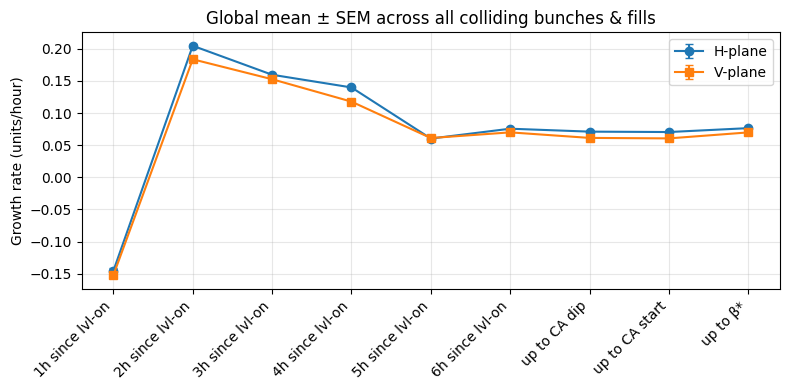

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------
# Assumes in your namespace:
#   fills: list of fill numbers
#   beam, ip, RAWDATA
#   LHCFillingPattern
#   load_STABLE_series, phase_markers_from_beta_xing,
#   leveling_on_time, build_windows_cumulative, robust_line
# -------------------------------------------------------

# 1) Build all_win_fits using *all* colliding slots (no families)
all_win_fits = {}
for fno in fills:
    # get the colliding‐bunch slots for this fill & beam
    fpat = LHCFillingPattern(fno, RAWDATA)
    slots = list(fpat.bunches_b1 if beam.upper()=='B1'
                 else fpat.bunches_b2)
    fams = {'ALL': slots}

    # compute stable‐windows fits for this fill
    df_w, fits_w = stable_window_rates_cumulative(fno, beam, fams)
    all_win_fits[fno] = fits_w

# 2) Collect every slot slope across all fills & windows
global_slopes = {}  # window_label -> {'H': [slope,...], 'V': [...]}
for fno, win_dict in all_win_fits.items():
    for win_label, fam_dict in win_dict.items():
        d = global_slopes.setdefault(win_label, {'H':[], 'V':[]})
        slot_dict = fam_dict['ALL']
        for (plane, slot), tup in slot_dict.items():
            slope = tup[0]
            if plane in ('H','V') and np.isfinite(slope):
                d[plane].append(slope)

# 3) Compute simple mean ± SEM for each window & plane
def mean_sem(arr):
    if not arr:
        return np.nan, np.nan, 0
    a = np.array(arr, float)
    m = a.mean()
    sem = a.std(ddof=1)/np.sqrt(a.size) if a.size>1 else 0.0
    return m, sem, a.size

rows = []
for win_label, planes in sorted(global_slopes.items()):
    H_mean, H_sem, H_n = mean_sem(planes['H'])
    V_mean, V_sem, V_n = mean_sem(planes['V'])
    rows.append({
        'window':   win_label,
        'H_mean':   H_mean,
        'H_sem':    H_sem,
        'H_n':      H_n,
        'V_mean':   V_mean,
        'V_sem':    V_sem,
        'V_n':      V_n,
    })

df_global_windows = (
    pd.DataFrame(rows)
      .set_index('window')
)

# 4) Display the table
print(df_global_windows)

# 5) Plot both planes
plt.figure(figsize=(8,4))
plt.errorbar(df_global_windows.index,
             df_global_windows['H_mean'],
             yerr=df_global_windows['H_sem'],
             fmt='-o', capsize=3, label='H‐plane')
plt.errorbar(df_global_windows.index,
             df_global_windows['V_mean'],
             yerr=df_global_windows['V_sem'],
             fmt='-s', capsize=3, label='V‐plane')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Growth rate (units/hour)')
plt.title('Global mean ± SEM across all colliding bunches & fills')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# 1) Helpers for bridge timing and fit evaluation
def get_bridge_interval(fno: int):
    sub = fbmodes.loc[fno].sort_values("tsStart")
    inj = sub[sub['BMODE'].str.upper()=="INJPHYS"]
    if inj.empty:
        raise RuntimeError(f"Fill {fno}: missing INJPHYS section")
    t_inj_end = pd.to_datetime(inj['tsEnd'].iloc[-1], utc=True)
    t_stb_on  = leveling_on_time(fno)
    if t_stb_on <= t_inj_end:
        raise RuntimeError(f"Fill {fno}: leveling‑on ({t_stb_on}) ≤ inj_end ({t_inj_end})")
    return t_inj_end, t_stb_on

def eval_fit_at_time(fit_tup, t_eval: pd.Timestamp):
    if fit_tup is None:
        return np.nan
    if len(fit_tup) == 5:
        m, b, _, t0, _ = fit_tup
    else:
        m, b, t0, _ = fit_tup
    return b + m * ((t_eval - t0).total_seconds()/3600.0)

# 2) Build per‑fill, per‑plane bridge rates
records = []
for fno in fills:
    # get all colliding slots for this fill & beam
    pat   = LHCFillingPattern(fno, RAWDATA)
    slots = pat.bunches_b1 if beam.upper()=="B1" else pat.bunches_b2

    # recompute STABLE‐window fits just for these "ALL" slots
    df_w, fits_w = stable_window_rates_cumulative(fno, beam, {'ALL': slots})
    first_win    = next(iter(fits_w))            # first stable‐window label
    stab_dict    = fits_w[first_win]['ALL']      # dict: (plane,slot) → (m,b,t0,ser)

    # bridge endpoints
    t0, t1 = get_bridge_interval(fno)
    dt_h   = (t1 - t0).total_seconds()/3600.0

    for plane in ("H","V"):
        slopes = []
        for slot in slots:
            # injection fit for this slot
            inj_tup = all_fits_global[fno].get(slot, {}).get(plane)
            # stable fit for same slot
            stab_tup = stab_dict.get((plane,slot))
            if inj_tup is None or stab_tup is None:
                continue
            y1 = eval_fit_at_time(inj_tup, t0)
            y2 = eval_fit_at_time(stab_tup, t1)
            if np.isfinite(y1) and np.isfinite(y2):
                slopes.append((y2 - y1)/dt_h)

        a = np.array(slopes, float)
        a = a[np.isfinite(a)]
        if a.size:
            mean = a.mean()
            sd   = a.std(ddof=1) if a.size>1 else 0.0
            sem  = sd/np.sqrt(a.size) if a.size>1 else 0.0
            n    = a.size
        else:
            mean = sem = np.nan
            n    = 0

        records.append({
            "fill":             fno,
            "plane":            plane,
            "bridge_mean":      mean,
            "bridge_sem":       sem,
            "n_slots_in_bridge":n
        })

df_bridge = (
    pd.DataFrame(records)
      .set_index(["fill","plane"])
      .sort_index()
)
display(df_bridge)

# 3) Finally, global average across fills
rows = []
for plane in ("H","V"):
    vals = df_bridge.xs(plane, level="plane")["bridge_mean"].dropna().values
    n    = vals.size
    if n:
        gm   = vals.mean()
        gsd  = vals.std(ddof=1) if n>1 else 0.0
        gsem = gsd/np.sqrt(n)  if n>1 else 0.0
    else:
        gm = gsem = np.nan
    rows.append({
        "plane":             plane,
        "global_bridge_mean":gm,
        "global_bridge_sem": gsem,
        "n_fills":           n
    })

df_global_bridge = pd.DataFrame(rows).set_index("plane")
display(df_global_bridge)



Fill 10665 markers:
  lvl_on     : 2025-05-24 21:19:05.427699+00:00
  beta_final : 2025-05-25 02:20:38.845363525+00:00
  CA start   : 2025-05-25 04:06:56.553000+00:00
  CA dip     : 2025-05-25 05:19:48.501000+00:00
Windows (cum ends):
  1h since lvl-on     end=2025-05-24 22:19:05.427699+00:00
  2h since lvl-on     end=2025-05-24 23:19:05.427699+00:00
  3h since lvl-on     end=2025-05-25 00:19:05.427699+00:00
  4h since lvl-on     end=2025-05-25 01:19:05.427699+00:00
  up to β*            end=2025-05-25 02:20:38.845363525+00:00
  up to CA start      end=2025-05-25 04:06:56.553000+00:00
  up to CA dip        end=2025-05-25 05:19:48.501000+00:00

Fill 10666 markers:
  lvl_on     : 2025-05-25 13:00:52.732165+00:00
  beta_final : 2025-05-25 18:08:24.201863525+00:00
  CA start   : 2025-05-25 20:02:23.501000+00:00
  CA dip     : 2025-05-25 21:23:41.501000+00:00
Windows (cum ends):
  1h since lvl-on     end=2025-05-25 14:00:52.732165+00:00
  2h since lvl-on     end=2025-05-25 15:00:52.732165+

# ALL


##  Injection

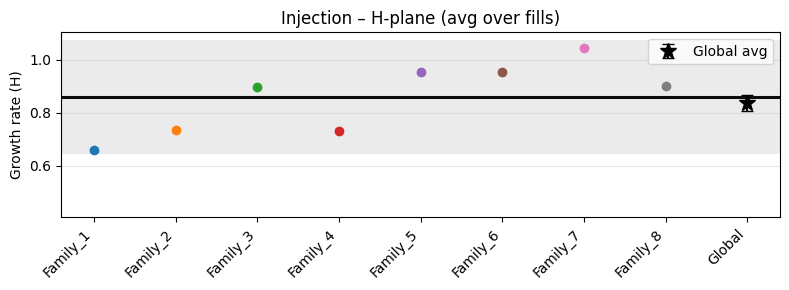

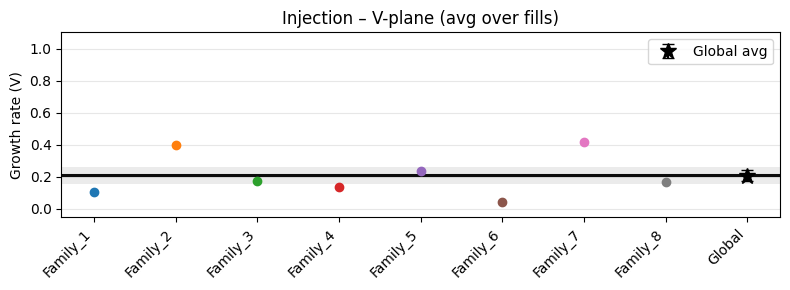

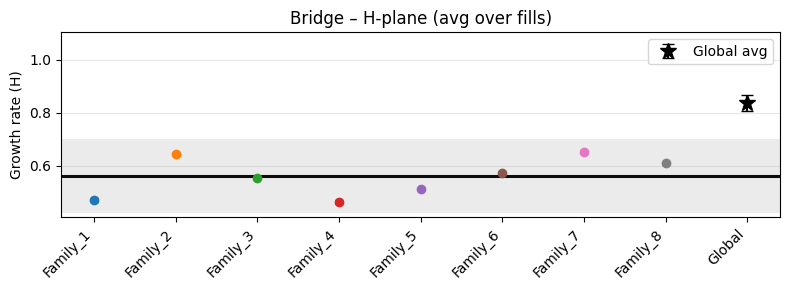

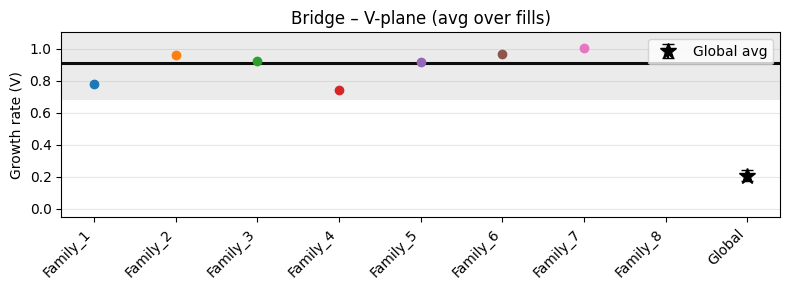

In [ ]:
# -------------------- colors --------------------
FAMILY_COLORS = {
    'Family_1': '#1f77b4', 'Family_2': '#ff7f0e', 'Family_3': '#2ca02c',
    'Family_4': '#d62728', 'Family_5': '#9467bd', 'Family_6': '#8c564b',
    'Family_7': '#e377c2', 'Family_8': '#7f7f7f',
}

# -------------------- column finders --------------------
def _find_mean_err_cols(df, plane):
    cols = df.columns
    patterns = [
        (f'{plane}_mean',        f'{plane}_sem'),
        (f'{plane}_rate_mean_w', f'{plane}_err_family'),
        (f'{plane}_bridge_mean', f'{plane}_bridge_sem'),
    ]
    for m, e in patterns:
        if m in cols:
            return m, (e if e in cols else None)
    raise KeyError(f"No mean column for plane={plane} in {list(cols)}")

def _err_sem(df, plane):
    _, err_col = _find_mean_err_cols(df, plane)
    return df[err_col].to_numpy() if err_col else np.full(len(df), np.nan)

def compute_common_ylim(dfs, plane, pad=0.1):
    vals = []
    for d in dfs:
        try:
            mcol, _ = _find_mean_err_cols(d, plane)
        except KeyError:
            continue
        vals.append(d[mcol].to_numpy())
    if not vals:
        return (0, 1)
    vals = np.concatenate(vals)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return (0, 1)
    vmin, vmax = vals.min(), vals.max()
    rng = vmax - vmin if vmax > vmin else 1.0
    return vmin - pad*rng, vmax + pad*rng

# -------------------- mean line + band --------------------
def draw_mean_band_rel(ax, values, frac=0.25,
                       line_color='k', band_color='k',
                       line_kw=None, band_kw=None):
    vals = np.asarray(values, float)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return
    m = np.nanmean(vals)
    band_abs = frac * abs(m)
    if band_abs < 1e-12:
        span = np.nanmax(vals) - np.nanmin(vals)
        band_abs = frac * span

    line_kw = dict(lw=2.2, alpha=0.95) | (line_kw or {})
    band_kw = dict(alpha=0.08, lw=0)  | (band_kw or {})

    ax.axhline(m, color=line_color, **line_kw)
    ax.axhspan(m - band_abs, m + band_abs, color=band_color, **band_kw)

# -------------------- INJ / BRIDGE (points) --------------------
def plot_phase_family_points(
    avg_df: pd.DataFrame,
    phase_name: str = 'Phase',
    plane: str = 'H',
    figsize=(8,3),
    ylim=None,
    band_frac=0.25,
    global_df: pd.DataFrame = None
):
    """
    avg_df      : flat DF indexed by family, must contain mean±sem columns
    phase_name  : label for the title
    plane       : 'H' or 'V'
    global_df   : df_global_rates (indexed by fill) to compute & plot one 'Global' point
    """
    fams        = avg_df.index.tolist()
    mean_col, _ = _find_mean_err_cols(avg_df, plane)
    means       = avg_df[mean_col].to_numpy()
    yerr        = _err_sem(avg_df, plane)

    x = np.arange(len(fams))
    colors = [FAMILY_COLORS.get(f, None) for f in fams]

    fig, ax = plt.subplots(figsize=figsize)

    # plot family‐level points
    for xi, m, e, c in zip(x, means, yerr, colors):
        ax.errorbar([xi], [m], yerr=[e], fmt='o', ms=6, capsize=3,
                    color=c, ecolor=c, linestyle='none')

    # global mean band (±25%)
    draw_mean_band_rel(ax, means, frac=band_frac)

    # add the Global point if requested
    if global_df is not None:
        # pull out the global mean±sem for this plane
        arr = global_df[f'{plane}_rate_mean_w'].dropna().to_numpy()
        if arr.size:
            gm   = arr.mean()
            gsem = arr.std(ddof=1)/np.sqrt(arr.size) if arr.size>1 else 0.0
            xg   = len(fams)
            ax.errorbar([xg], [gm], yerr=[gsem],
                        fmt='*', ms=12, capsize=4,
                        color='black', ecolor='black',
                        label='Global avg')
            # extend the ticks
            ax.set_xticks(list(x) + [xg])
            ax.set_xticklabels(fams + ['Global'], rotation=45, ha='right')

    else:
        ax.set_xticks(x)
        ax.set_xticklabels(fams, rotation=45, ha='right')

    ax.set_ylabel(f'Growth rate ({plane})')
    ax.set_title(f'{phase_name} – {plane}-plane (avg over fills)')
    ax.grid(axis='y', alpha=0.3)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# -------------------- example calls --------------------
# compute common y‐limits
ylim_H = compute_common_ylim([inj_avg, bridge_avg, stable_avg], 'H')
ylim_V = compute_common_ylim([inj_avg, bridge_avg, stable_avg], 'V')

# plot injection with global
plot_phase_family_points(
    inj_avg, 'Injection', 'H',
    ylim=ylim_H, band_frac=0.25,
    global_df=df_global_rates
)
plot_phase_family_points(
    inj_avg, 'Injection', 'V',
    ylim=ylim_V, band_frac=0.25,
    global_df=df_global_rates
)

# plot bridge with global
plot_phase_family_points(
    bridge_avg, 'Bridge', 'H',
    ylim=ylim_H, band_frac=0.25,
    global_df=df_global_rates
)
plot_phase_family_points(
    bridge_avg, 'Bridge', 'V',
    ylim=ylim_V, band_frac=0.25,
    global_df=df_global_rates
)


## Stable


Fill 10665 markers:
  lvl_on     : 2025-05-24 21:19:05.427699+00:00
  beta_final : 2025-05-25 02:20:38.845363525+00:00
  CA start   : 2025-05-25 04:06:56.553000+00:00
  CA dip     : 2025-05-25 05:19:48.501000+00:00
Windows (cum ends):
  1h since lvl-on     end=2025-05-24 22:19:05.427699+00:00
  2h since lvl-on     end=2025-05-24 23:19:05.427699+00:00
  3h since lvl-on     end=2025-05-25 00:19:05.427699+00:00
  4h since lvl-on     end=2025-05-25 01:19:05.427699+00:00
  up to β*            end=2025-05-25 02:20:38.845363525+00:00
  up to CA start      end=2025-05-25 04:06:56.553000+00:00
  up to CA dip        end=2025-05-25 05:19:48.501000+00:00

Fill 10666 markers:
  lvl_on     : 2025-05-25 13:00:52.732165+00:00
  beta_final : 2025-05-25 18:08:24.201863525+00:00
  CA start   : 2025-05-25 20:02:23.501000+00:00
  CA dip     : 2025-05-25 21:23:41.501000+00:00
Windows (cum ends):
  1h since lvl-on     end=2025-05-25 14:00:52.732165+00:00
  2h since lvl-on     end=2025-05-25 15:00:52.732165+


Fill 10721 markers:
  lvl_on     : 2025-06-15 19:20:29.286781+00:00
  beta_final : 2025-06-16 01:45:33.126238525+00:00
  CA start   : 2025-06-16 03:26:40.501000+00:00
  CA dip     : 2025-06-16 04:41:36.536000+00:00
Windows (cum ends):
  1h since lvl-on     end=2025-06-15 20:20:29.286781+00:00
  2h since lvl-on     end=2025-06-15 21:20:29.286781+00:00
  3h since lvl-on     end=2025-06-15 22:20:29.286781+00:00
  4h since lvl-on     end=2025-06-15 23:20:29.286781+00:00
  5h since lvl-on     end=2025-06-16 00:20:29.286781+00:00
  up to β*            end=2025-06-16 01:45:33.126238525+00:00
  up to CA start      end=2025-06-16 03:26:40.501000+00:00
  up to CA dip        end=2025-06-16 04:41:36.536000+00:00

Fill 10732 markers:
  lvl_on     : 2025-06-18 07:58:24.199009+00:00
  beta_final : 2025-06-18 15:01:39.473363525+00:00
  CA start   : 2025-06-19 02:13:53.501000+00:00
  CA dip     : 2025-06-19 02:13:53.501000+00:00
Windows (cum ends):
  1h since lvl-on     end=2025-06-18 08:58:24.199009+

/tmp/ipykernel_780329/842149338.py:176: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_global_windows.index, rotation=45, ha='right')


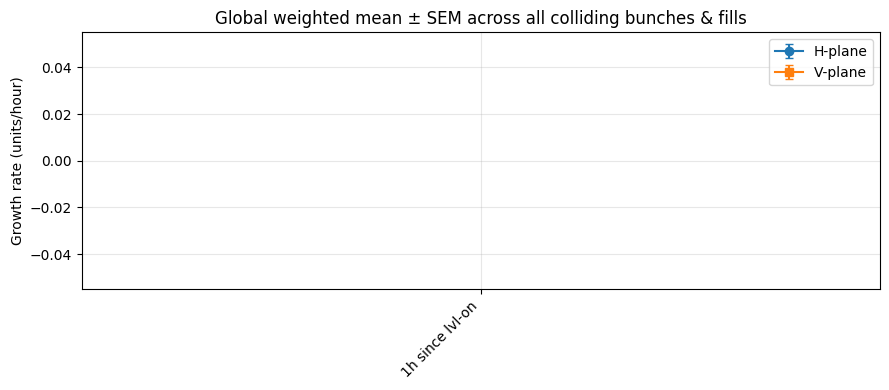

In [ ]:
# ---------------------------------------------------------------------------------
# CONFIG & CONSTANTS  ──────────────────────────────────────────────────────────────
# ---------------------------------------------------------------------------------
MAKE_HOURLY   = True        # set False if you only want optics‑phase windows
MIN_PTS       = 5           # ≥ points in a fit segment
THRESH_CA     = 120.0       # for phase_markers_from_beta_xing()
F_SCALE       = 0.1         # robust_line fit parameter
REL_ERR       = 0.05
ABS_ERR_FLOOR = 0.02
MIN_ERR       = 1e-12
# BETA_PV, XING_PV, LEV_PV, etc. already assumed in your namespace
from lmfit import Model 
# ---------------------------------------------------------------------------------
#  UTILITIES  ──────────────────────────────────────────────────────────────────────
# ---------------------------------------------------------------------------------
def bsrt_loc_for_beam(beam: str) -> str:
    return '5R4' if beam.upper() == 'B1' else '5L4'


_line_model = lmfit.Model(lambda x, m, b: m*x + b)

def robust_line(x_hours: np.ndarray, y: np.ndarray):
    """Soft‑L1 robust linear fit, returns m, b, σ_m, lmfit.result"""
    yerr = np.maximum(np.maximum(REL_ERR*np.abs(y), ABS_ERR_FLOOR), MIN_ERR)
    w    = 1.0 / yerr
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        res = _line_model.fit(y, x=x_hours, m=0.0, b=y[0],
                              weights=w,
                              method='least_squares',
                              fit_kws={'loss':'soft_l1','f_scale':F_SCALE})
    m  = res.params['m'].value
    b  = res.params['b'].value
    sm = res.params['m'].stderr or np.nan
    return m, b, sm, res

def _wmean_sem_spread(pairs):
    """pairs = [(value, σ), …]   → wmean, wsem, wstd, wmad, N"""
    if not pairs:
        return (np.nan, np.nan, np.nan, np.nan, 0)
    v  = np.array([v for v,_ in pairs], float)
    s  = np.array([e for _,e in pairs], float)
    ok = np.isfinite(v) & np.isfinite(s) & (s > 0)
    if ok.sum() == 0:
        return (np.nan,)*4 + (0,)
    w     = 1.0 / s[ok]**2
    mean  = np.sum(w*v[ok]) / np.sum(w)
    sem   = np.sqrt(1.0 / np.sum(w))
    std   = np.std(v[ok], ddof=1) if ok.sum() > 1 else np.nan
    mad   = 1.4826*np.median(np.abs(v[ok]-np.median(v[ok]))) if ok.sum() > 1 else np.nan
    return mean, sem, std, mad, int(ok.sum())

def wmean_sem(slopes_and_errors):
    """list[(m,σ)] → weighted mean, sem, N  (filters non‑finite & σ≤0)"""
    if not slopes_and_errors:
        return np.nan, np.nan, 0
    a = np.array([m for m,_ in slopes_and_errors], float)
    e = np.array([s for _,s in slopes_and_errors], float)
    ok = np.isfinite(a) & np.isfinite(e) & (e>0)
    if ok.sum() == 0:
        return np.nan, np.nan, 0
    w = 1.0 / e[ok]**2
    return (np.sum(w*a[ok]) / np.sum(w),
            np.sqrt(1.0/np.sum(w)),
            int(ok.sum()))

# ---------------------------------------------------------------------------------
#  CORE: cumulative‑window fits for ONE fill  ─────────────────────────────────────
# ---------------------------------------------------------------------------------
def stable_window_rates_cumulative(
        fno:   int,
        beam:  str,
        fams:  dict[str, list[int]],
) -> tuple[pd.DataFrame, dict]:
    """
    fams example: {'ALL': [list_of_slots]}  – if you pass real families you’ll
    get per‑family results; but here we use a single key 'ALL'.
    """
    # markers & raw series ------------------------------------------------------
    ser_beta  = load_STABLE_series(BETA_PV, fno)
    ser_xing  = load_STABLE_series(XING_PV, fno)
    t_beta_final, t_ca_start, t_ca_dip = phase_markers_from_beta_xing(
        ser_beta, ser_xing, THRESH_CA)
    t_on      = leveling_on_time(fno)

    loc   = bsrt_loc_for_beam(beam)
    ser_H = load_STABLE_series(f"LHC.BSRT.{loc}.{beam}:BUNCH_EMITTANCE_H", fno)
    ser_V = load_STABLE_series(f"LHC.BSRT.{loc}.{beam}:BUNCH_EMITTANCE_V", fno)

    windows = build_windows_cumulative(
        t_on, t_beta_final, t_ca_start, t_ca_dip,
        ser_H, ser_V, make_hourly=MAKE_HOURLY)

    if not windows:                                             # <── guard
        raise RuntimeError(f"Fill {fno}: no windows generated")

    # pre‑slice raw series per slot once
    rawH = {s: extract_slot(ser_H, s).sort_index()
            for slots in fams.values() for s in slots}
    rawV = {s: extract_slot(ser_V, s).sort_index()
            for slots in fams.values() for s in slots}

    rows, fits = [], {}
    for label, _, t_end in windows:
        fits[label] = {}
        row = {'fill': fno, 'window': label}

        for fam, slots in fams.items():
            fits[label][fam] = {}
            H_pairs, V_pairs = [], []

            for s in slots:
                # H
                segH = rawH[s].loc[t_on:t_end].dropna()
                if segH.size >= MIN_PTS:
                    xh = (segH.index - t_on).total_seconds()/3600.0
                    sh, ih, sh_err, _ = robust_line(xh, segH.values)
                else:
                    sh = ih = sh_err = np.nan
                fits[label][fam][('H',s)] = (sh, ih, sh_err, t_on, segH)
                if np.isfinite(sh_err) and sh_err>0 and np.isfinite(sh):
                    H_pairs.append((sh, sh_err))

                # V
                segV = rawV[s].loc[t_on:t_end].dropna()
                if segV.size >= MIN_PTS:
                    xv = (segV.index - t_on).total_seconds()/3600.0
                    sv, iv, sv_err, _ = robust_line(xv, segV.values)
                else:
                    sv = iv = sv_err = np.nan
                fits[label][fam][('V',s)] = (sv, iv, sv_err, t_on, segV)
                if np.isfinite(sv_err) and sv_err>0 and np.isfinite(sv):
                    V_pairs.append((sv, sv_err))

            # aggregate per (fill, window, fam)
            H_mean, H_sem, *_ , H_n = _wmean_sem_spread(H_pairs)
            V_mean, V_sem, *_ , V_n = _wmean_sem_spread(V_pairs)
            row.update({
                f'{fam}_H_mean': H_mean, f'{fam}_H_sem': H_sem, f'{fam}_H_n': H_n,
                f'{fam}_V_mean': V_mean, f'{fam}_V_sem': V_sem, f'{fam}_V_n': V_n
            })

        rows.append(row)

    return pd.DataFrame(rows).set_index(['fill','window']), fits

# ---------------------------------------------------------------------------------
#  DRIVER ACROSS ALL FILLS  ───────────────────────────────────────────────────────
# ---------------------------------------------------------------------------------
all_win_fits = {}          # fill -> windows -> slot‑fits
global_slopes = {}         # window -> {'H':[(m,σ)…],'V':[(m,σ)…]}

for fno in fills:
    slots = list((LHCFillingPattern(fno, RAWDATA).bunches_b1
                  if beam.upper()=='B1' else
                  LHCFillingPattern(fno, RAWDATA).bunches_b2))
    df_fill, fits_fill = stable_window_rates_cumulative(
        fno, beam, {'ALL': slots})
    all_win_fits[fno] = fits_fill

    # gather slopes+errs
    for win_lbl, famdict in fits_fill.items():
        g = global_slopes.setdefault(win_lbl, {'H':[], 'V':[]})
        for (plane, slot), (m, _, err, *_ ) in famdict['ALL'].items():
            if plane in ('H','V') and np.isfinite(m) and np.isfinite(err) and err>0:
                g[plane].append((m, err))

# ---------------------------------------------------------------------------------
#  AGGREGATE ACROSS FILLS & PLOT  ─────────────────────────────────────────────────
# ---------------------------------------------------------------------------------
records = []
for win_lbl in sorted(global_slopes):
    H_mean, H_sem, H_n = wmean_sem(global_slopes[win_lbl]['H'])
    V_mean, V_sem, V_n = wmean_sem(global_slopes[win_lbl]['V'])
    records.append({'window':win_lbl,
                    'H_mean':H_mean,'H_sem':H_sem,'H_n':H_n,
                    'V_mean':V_mean,'V_sem':V_sem,'V_n':V_n})

df_global = (pd.DataFrame(records)
               .set_index('window')
               .sort_index())

print(df_global)   # ← full table

fig, ax = plt.subplots(figsize=(9,4))
ax.errorbar(df_global.index, df_global['H_mean'], yerr=df_global['H_sem'],
            fmt='-o', capsize=3, label='H‑plane')
ax.errorbar(df_global.index, df_global['V_mean'], yerr=df_global['V_sem'],
            fmt='-s', capsize=3, label='V‑plane')
ax.set_xticklabels(df_global.index, rotation=45, ha='right')
ax.set_ylabel('Growth rate (units / hour)')
ax.set_title('Global weighted mean ± SEM across all colliding bunches & fills')
ax.grid(alpha=0.3); ax.legend(); fig.tight_layout(); plt.show()


# Ips

## Injection

## STABLE

## BRIDGE